## Objective 

1. **Train  Predictive Model:** Start by training a machine learning model on your dataset, which you aim to predict the target variable.

2. **Compute SHAP Values:** Calculate SHAP values for the predictions made by your model on the training data. These values provide a detailed explanation of the contribution of each input feature to the prediction.

3. **Training the Explanation Model:** Next, train a separate model (which can be a Gaussian Process or any other regression model) that uses the input features to predict the SHAP values calculated in the previous step. This model aims to predict the contribution of each feature for any given input instance.

4. **Prediction of Explanations:** For any new, unseen instance \(x\), use the explanation model to predict the SHAP values. This gives us an anticipated explanation of how each feature contributes to the model's prediction for \(x\).

5. **Comparison and Analysis:** Finally, compare the predicted explanations with the actual outcomes and the model's predictions to evaluate the accuracy and reliability of the explanation model. This step involves analyzing how well the predicted SHAP values match the true contributions of features to the prediction.

## Import packages

In [205]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import catboost
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

## Processing the data
### Importing the data
+ The variable description: https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf  
+ The original data: https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system?select=2015.csv  
+ The simplified data (this data): https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data  
+ How the data is cleaned and simplified: https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook#Diabetes-Health-Indicators-Dataset-Notebook

In [43]:
# Load your dataset
file_path = 'diabetes_data_2.csv'
df = pd.read_csv(file_path)

# Separate the dataset by category
data_0 = df[df['Diabetes_binary'] == 0]
data_1 = df[df['Diabetes_binary'] == 1]

# Sample 5000 from each category
sampled_data_0 = data_0.sample(n=5000, random_state=42)
sampled_data_1 = data_1.sample(n=5000, random_state=42)

# Combine the samples
diabetes_data = pd.concat([sampled_data_0, sampled_data_1])

# Verify the sampling
print(diabetes_data['Diabetes_binary'].value_counts())

# Display the first few rows of the sampled data
print(diabetes_data.head())

Diabetes_binary
0.0    5000
1.0    5000
Name: count, dtype: int64
        Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
9362                0.0     0.0       0.0        1.0  27.0     1.0     0.0   
1082                0.0     1.0       1.0        1.0  25.0     0.0     0.0   
148278              0.0     1.0       0.0        1.0  21.0     0.0     0.0   
57301               0.0     0.0       0.0        1.0  23.0     0.0     0.0   
127572              0.0     0.0       0.0        1.0  27.0     0.0     0.0   

        HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
9362                     0.0           1.0     1.0  ...            1.0   
1082                     0.0           0.0     0.0  ...            1.0   
148278                   0.0           1.0     0.0  ...            1.0   
57301                    0.0           0.0     1.0  ...            1.0   
127572                   0.0           1.0     1.0  ...            1.0   

        NoDocbcCost 

### Ensuring the correct type of each column
Specify the type for each column

In [44]:
# Convert binary and categorical variables
binary_columns = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 
                  'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 
                  'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
# Norminal categorical variables
nominal_columns = ['Education', 'Income', 'GenHlth']
# Numeric variables
numeric_columns = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
# Categorical variables
categorical_features = binary_columns + nominal_columns
# Target (norminal categorical) variable
target_column = 'Diabetes_binary'

Convert each column to specified type and print the summary

In [6]:
for col in categorical_features:  
    diabetes_data[col] = diabetes_data[col].astype('category')

for col in numeric_columns:
    diabetes_data[col] = pd.to_numeric(diabetes_data[col], errors='coerce')

diabetes_data[target_column] = diabetes_data[target_column].astype('category')

# Summary of each variable
summary = diabetes_data.describe(include='all').transpose()
print(summary)

                        count  unique  top    freq     mean        std   min  \
Diabetes_binary       10000.0     2.0  0.0  5000.0      NaN        NaN   NaN   
HighBP                10000.0     2.0  1.0  5576.0      NaN        NaN   NaN   
HighChol              10000.0     2.0  1.0  5335.0      NaN        NaN   NaN   
CholCheck             10000.0     2.0  1.0  9767.0      NaN        NaN   NaN   
BMI                   10000.0     NaN  NaN     NaN  29.8549   7.387320  14.0   
Smoker                10000.0     2.0  0.0  5210.0      NaN        NaN   NaN   
Stroke                10000.0     2.0  0.0  9413.0      NaN        NaN   NaN   
HeartDiseaseorAttack  10000.0     2.0  0.0  8481.0      NaN        NaN   NaN   
PhysActivity          10000.0     2.0  1.0  7044.0      NaN        NaN   NaN   
Fruits                10000.0     2.0  1.0  6110.0      NaN        NaN   NaN   
Veggies               10000.0     2.0  1.0  7917.0      NaN        NaN   NaN   
HvyAlcoholConsump     10000.0     2.0  0

### Checking for any missing value

In [7]:
rows_with_missing_values = diabetes_data[diabetes_data.isnull().any(axis=1)]
print(rows_with_missing_values.head())

Empty DataFrame
Columns: [Diabetes_binary, HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age, Education, Income]
Index: []

[0 rows x 22 columns]


There seems to be no missing value with this cleaned version of data set

## Initial visualisaton
### Plotting distribution for numerical variables

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

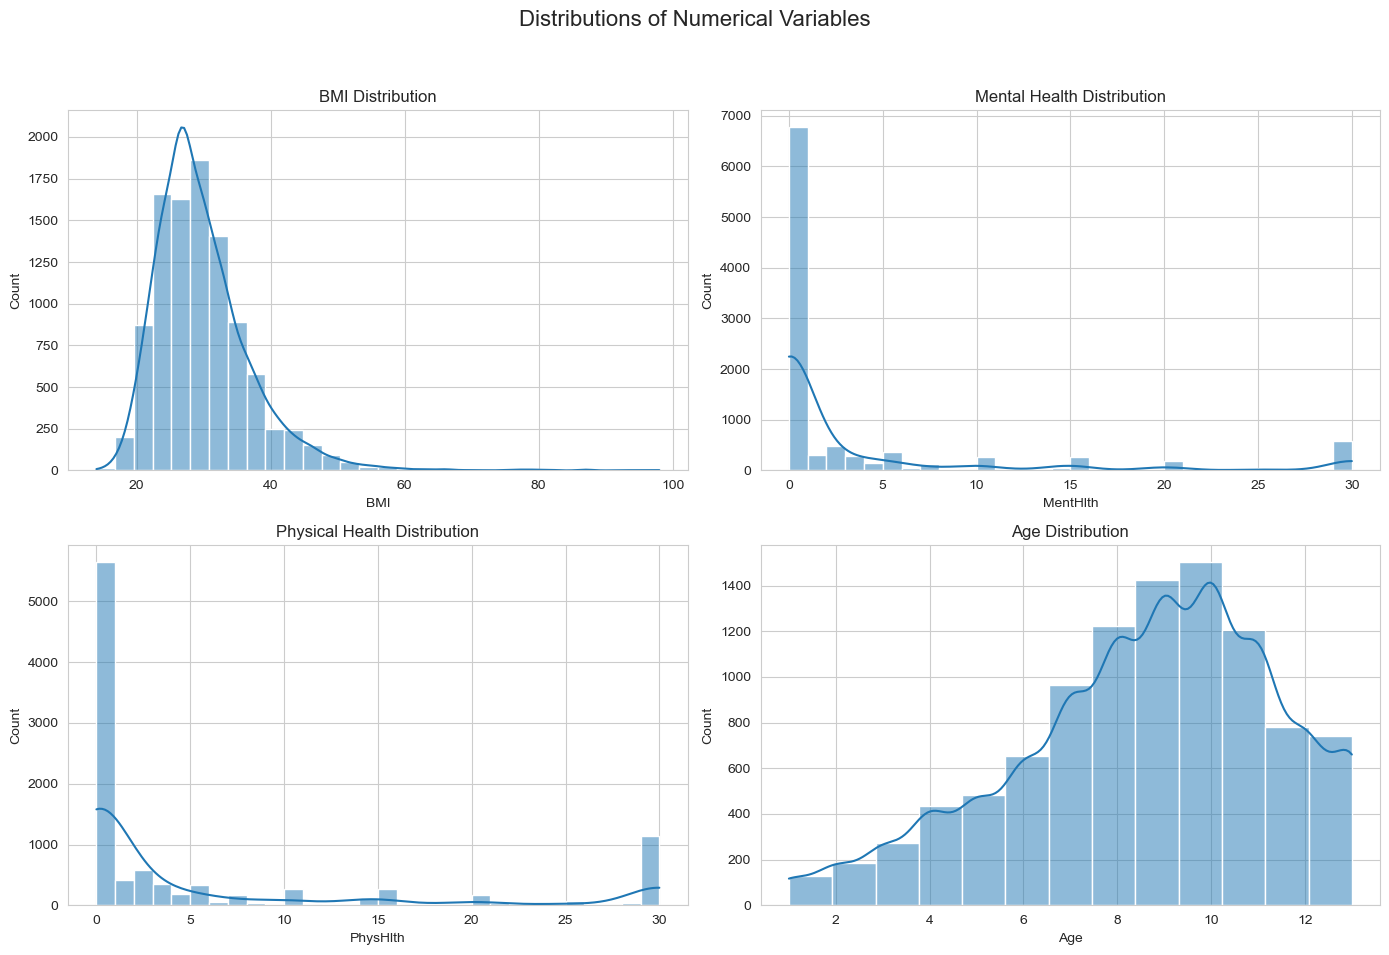

In [8]:
# Plotting distributions
sns.set_style("whitegrid")

# Numerical variables' histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Distributions of Numerical Variables', fontsize=16)

sns.histplot(diabetes_data['BMI'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('BMI Distribution')

sns.histplot(diabetes_data['MentHlth'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Mental Health Distribution')

sns.histplot(diabetes_data['PhysHlth'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Physical Health Distribution')

sns.histplot(diabetes_data['Age'], bins=13, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Age Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

### Plotting distribution for categorical variables

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gr

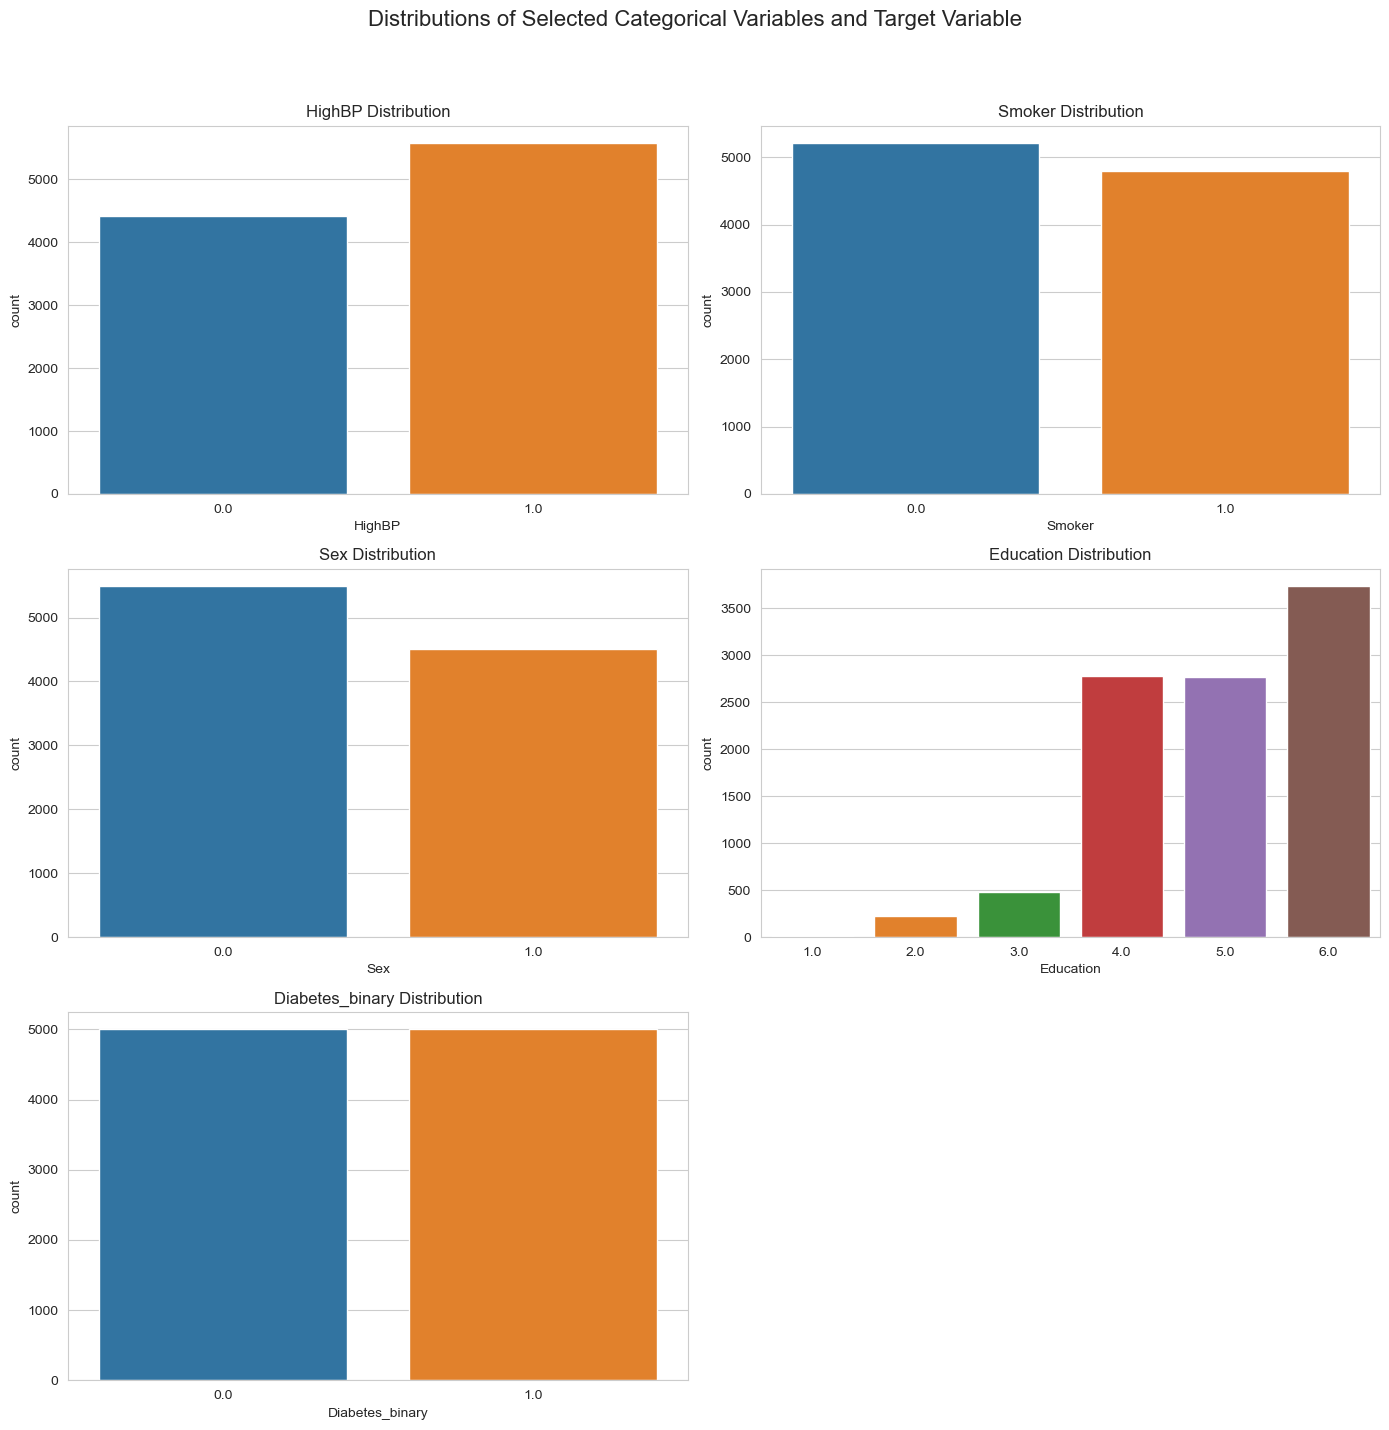

In [9]:
categorical_subset = ['HighBP', 'Smoker', 'Sex', 'Education', 'Diabetes_binary']

# Adjusting the plot grid to accommodate the additional variable
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
fig.suptitle('Distributions of Selected Categorical Variables and Target Variable', fontsize=16)

# Removing the empty subplot (since we now have an odd number of variables to plot)
fig.delaxes(axes[2,1])

for i, col in enumerate(categorical_subset):
    sns.countplot(x=col, data=diabetes_data, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
# Calculate Pearson correlation
diabetes_data[['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Diabetes_binary']].corr()

BMI  MentHlth  PhysHlth       Age  Diabetes_binary
BMI              1.000000  0.099746  0.154545 -0.037896         0.283270
MentHlth         0.099746  1.000000  0.385984 -0.091478         0.076359
PhysHlth         0.154545  0.385984  1.000000  0.084932         0.196966
Age             -0.037896 -0.091478  0.084932  1.000000         0.276168
Diabetes_binary  0.283270  0.076359  0.196966  0.276168         1.000000

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


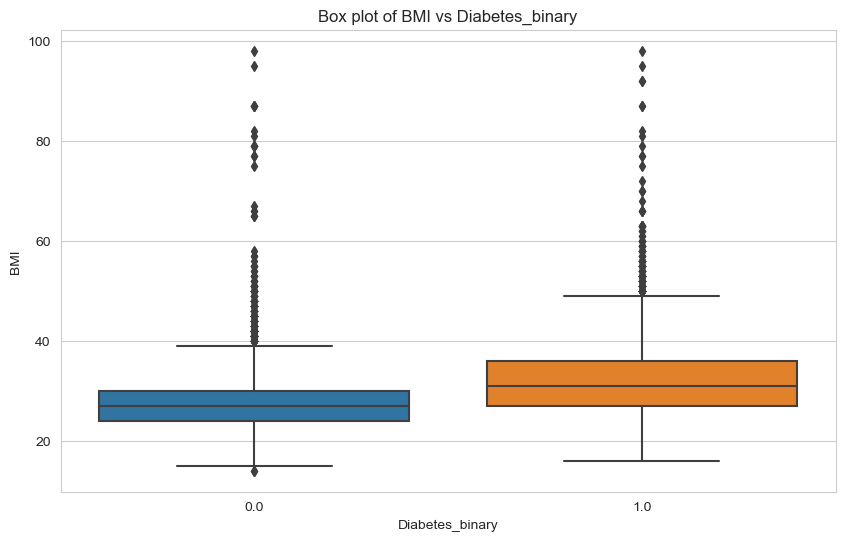

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


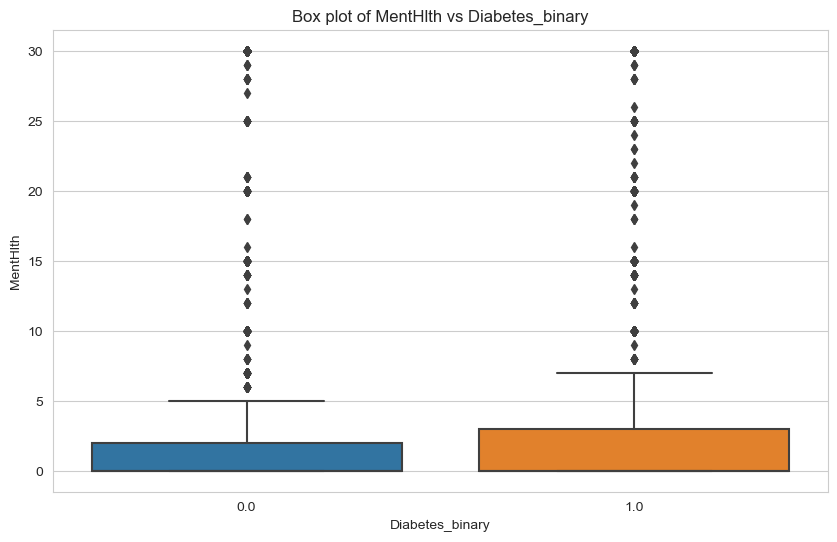

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


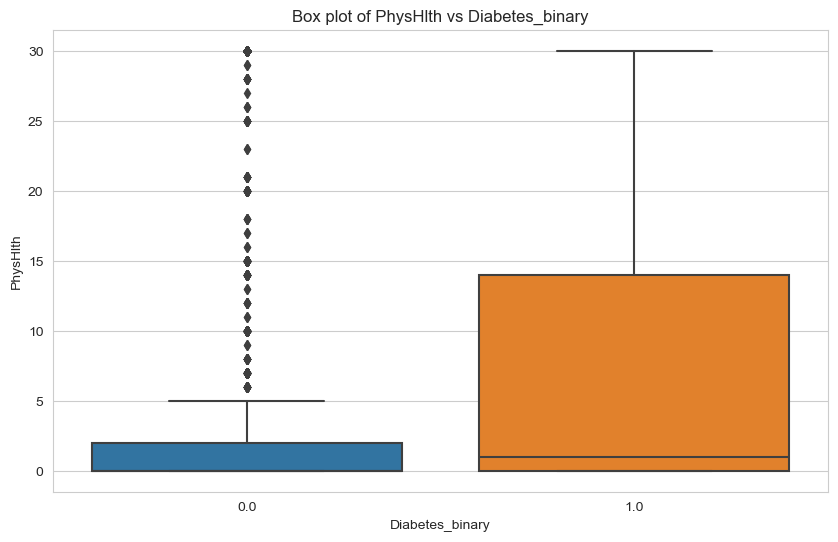

C:\Users\ACER\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


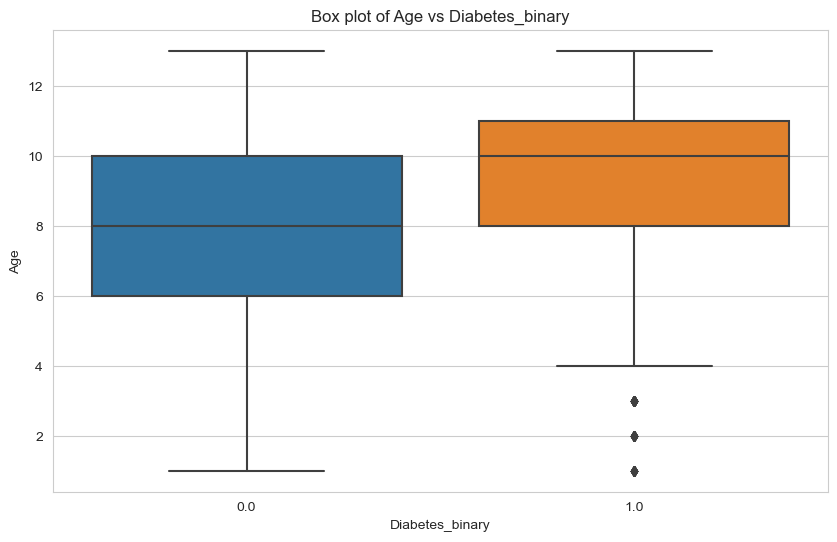

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming diabetes_data is your DataFrame and it's already loaded
numeric_columns = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
target_column = 'Diabetes_binary'

# Plot boxplots for each numerical column against the target variable
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target_column, y=col, data=diabetes_data)
    plt.title(f'Box plot of {col} vs {target_column}')
    plt.show()

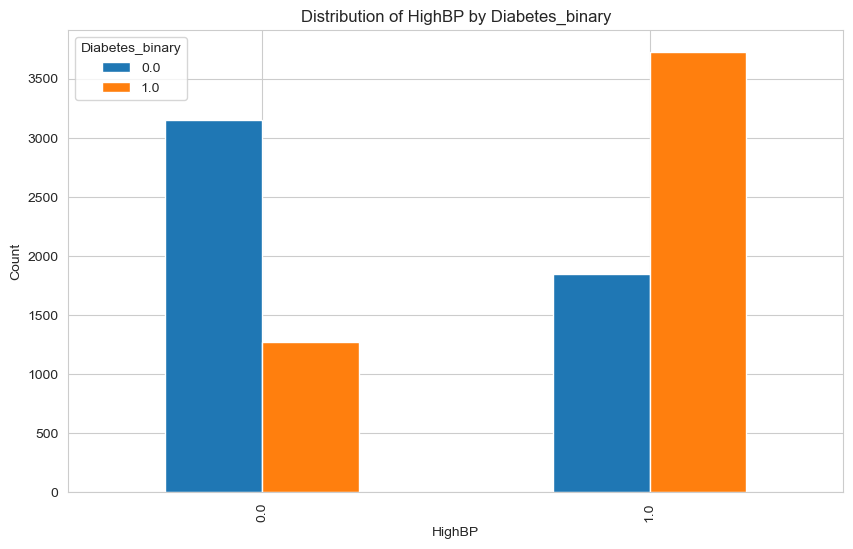

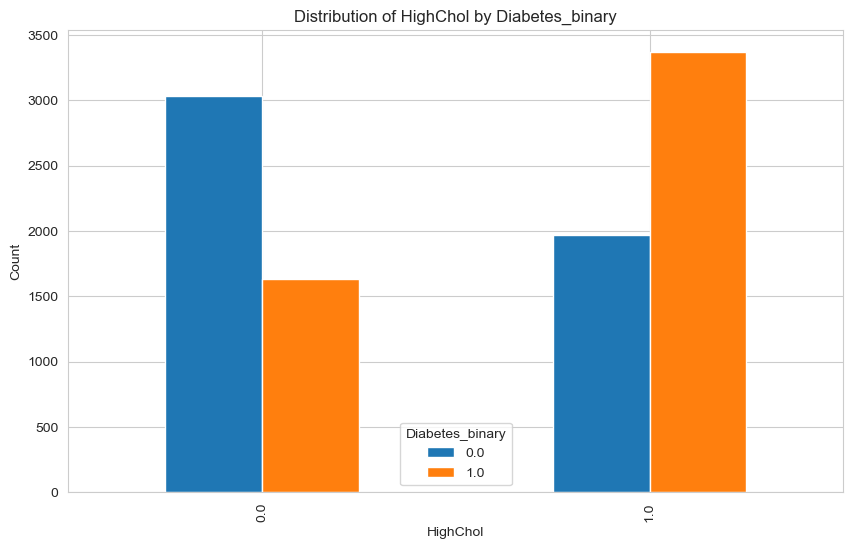

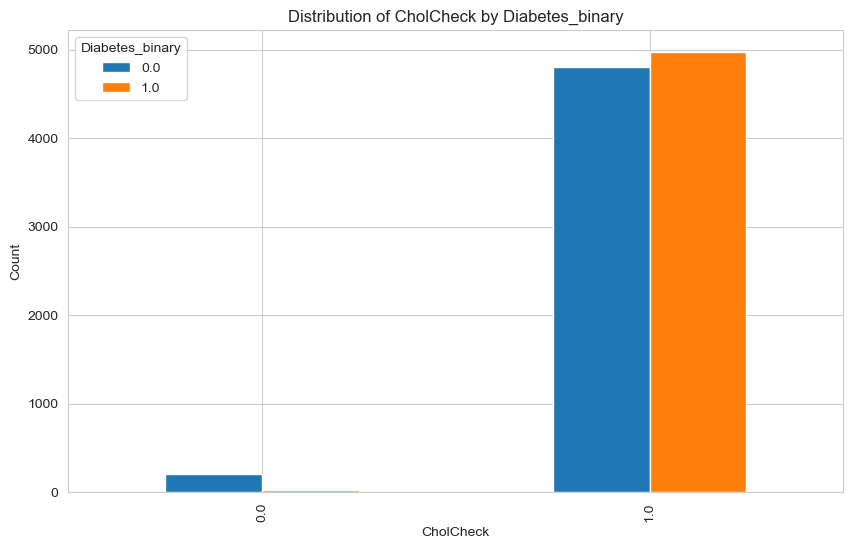

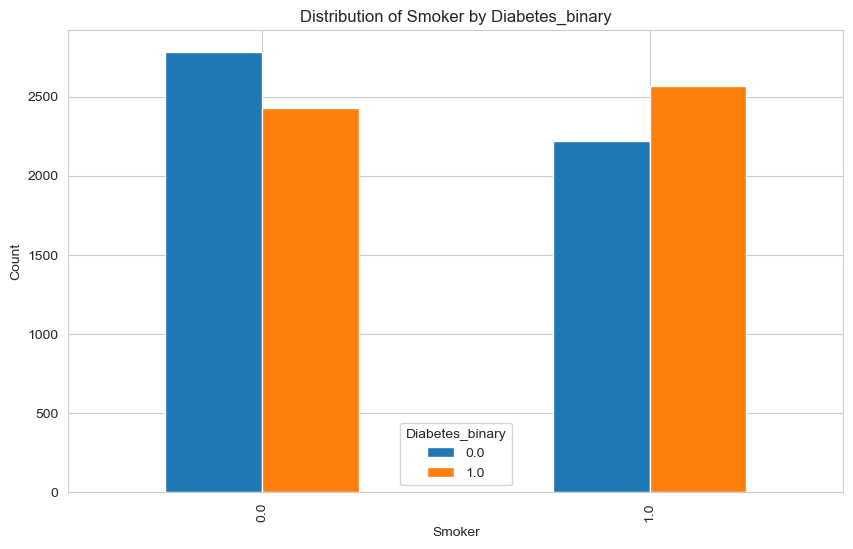

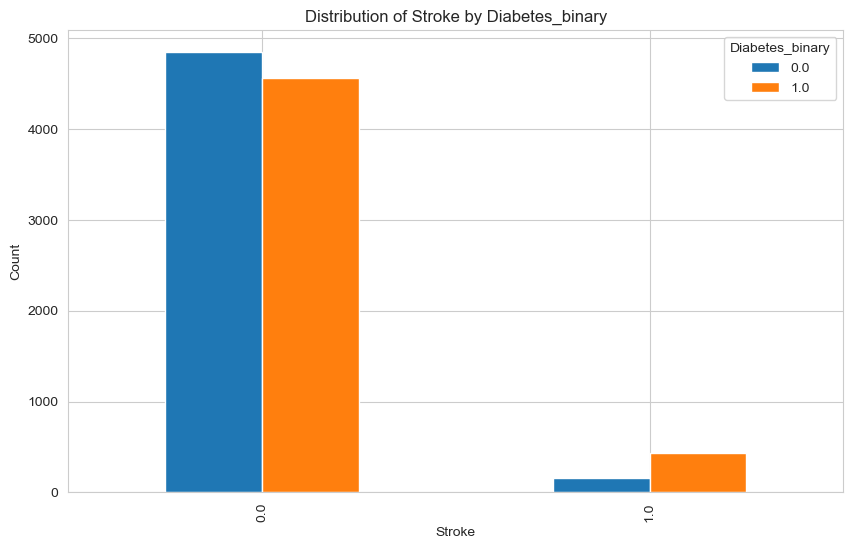

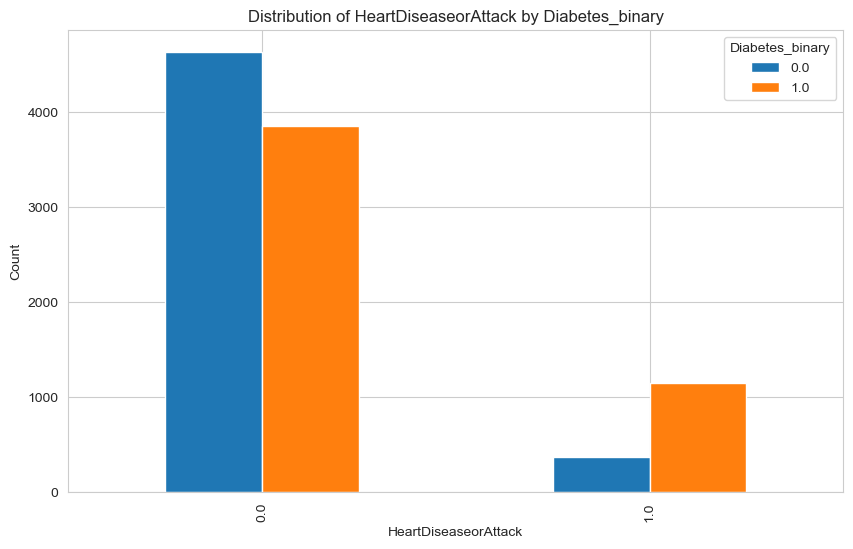

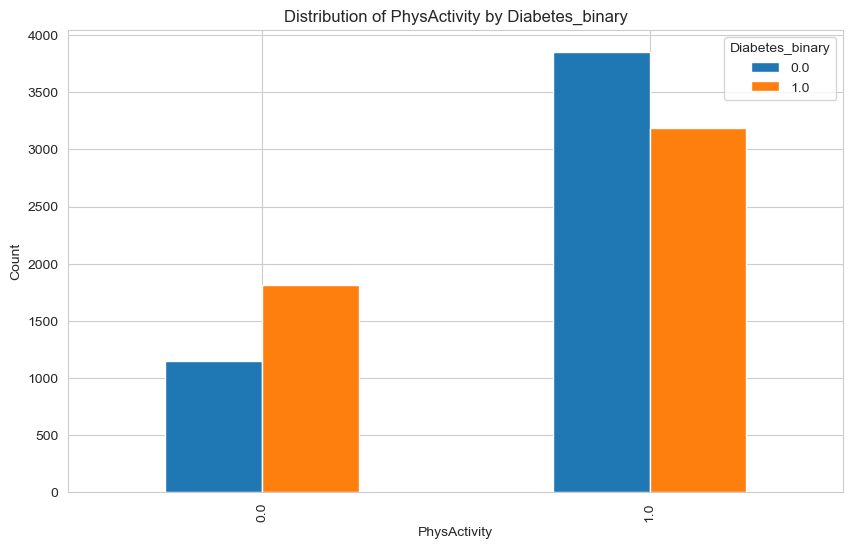

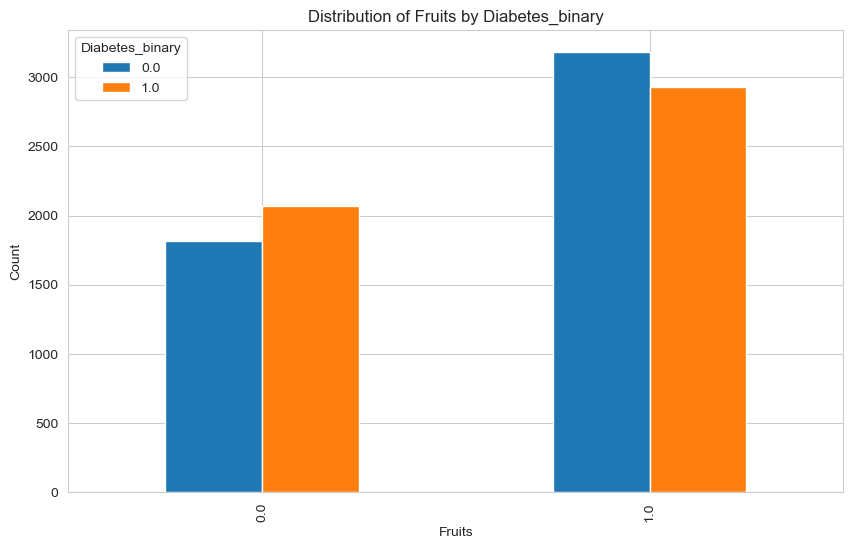

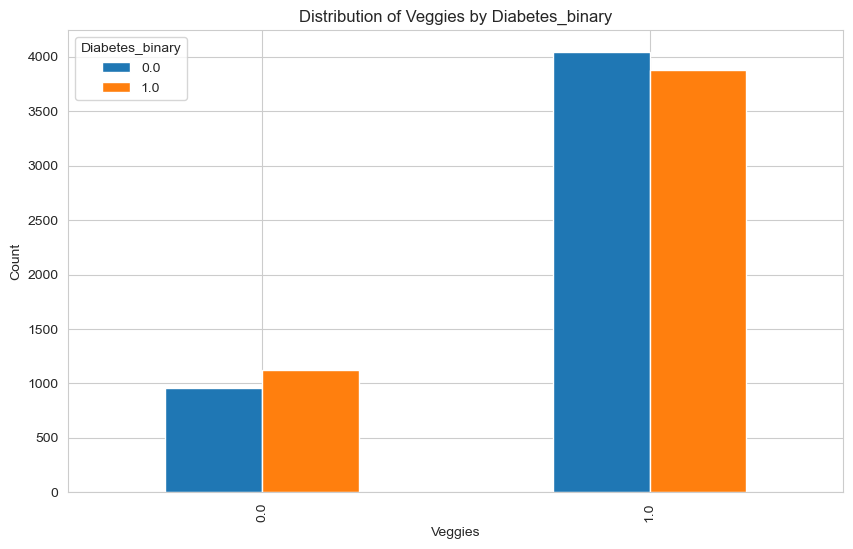

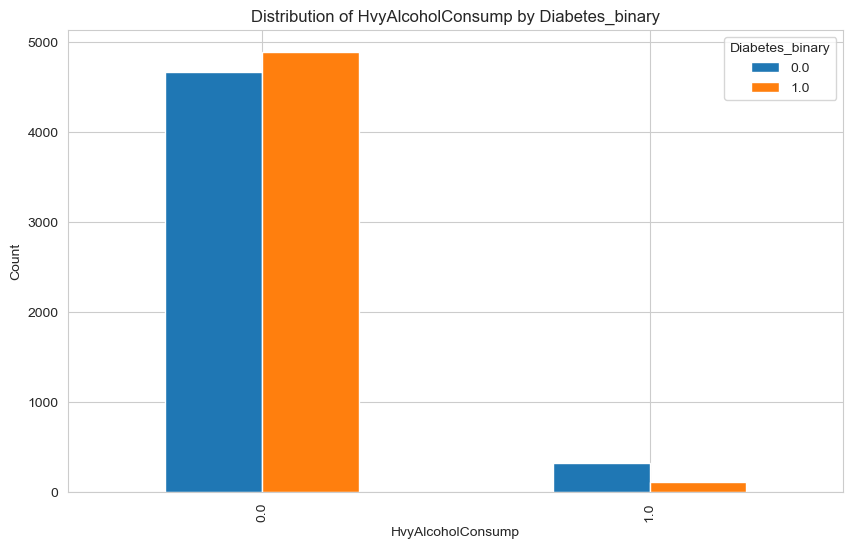

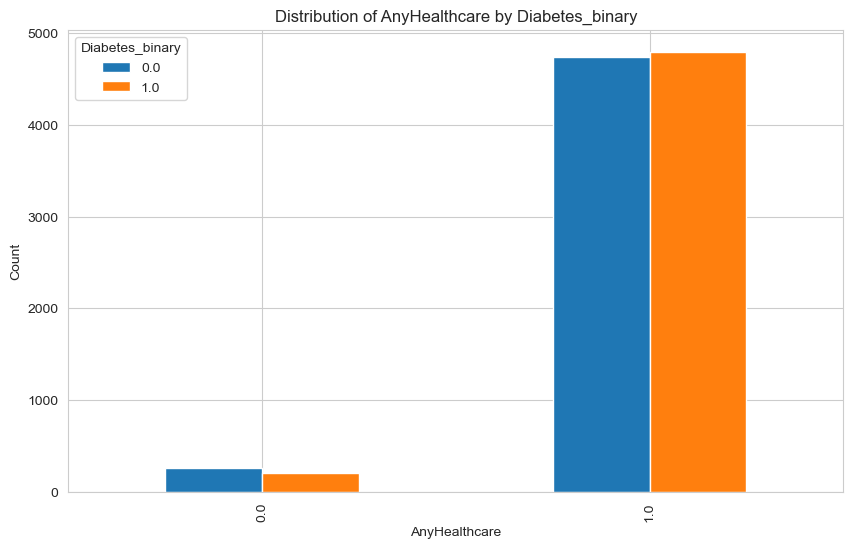

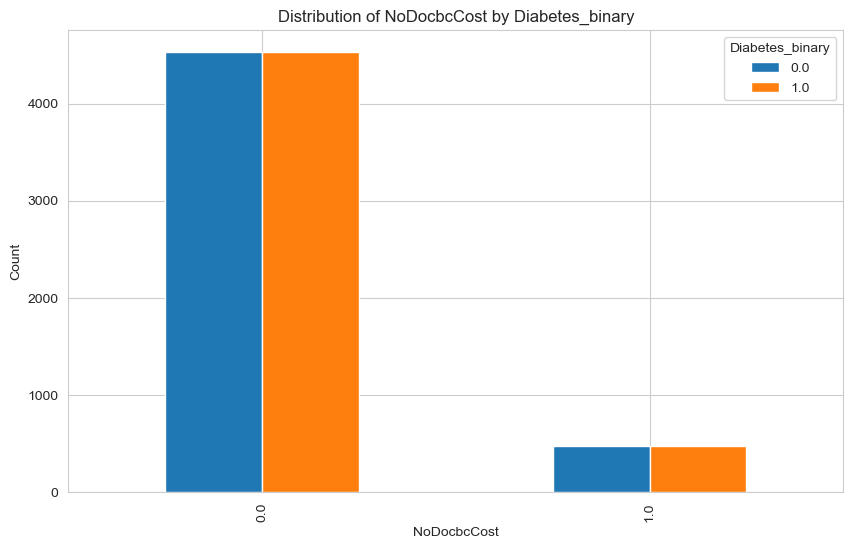

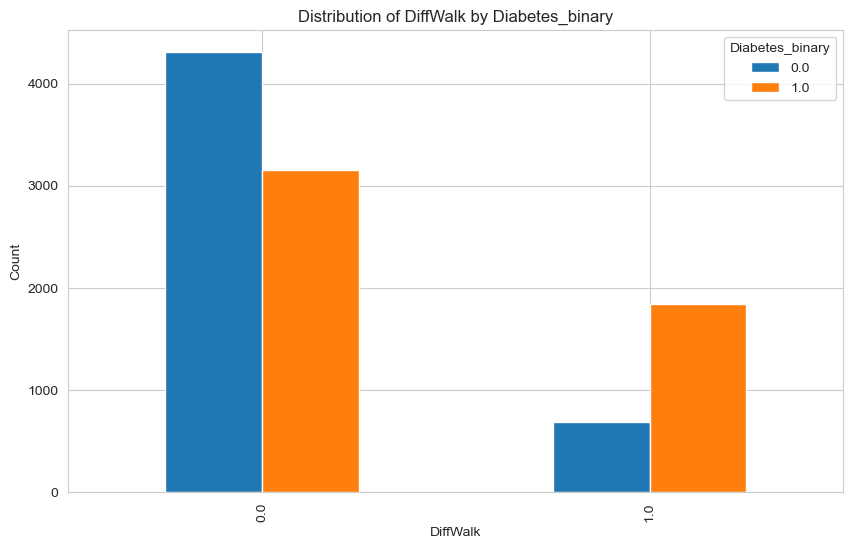

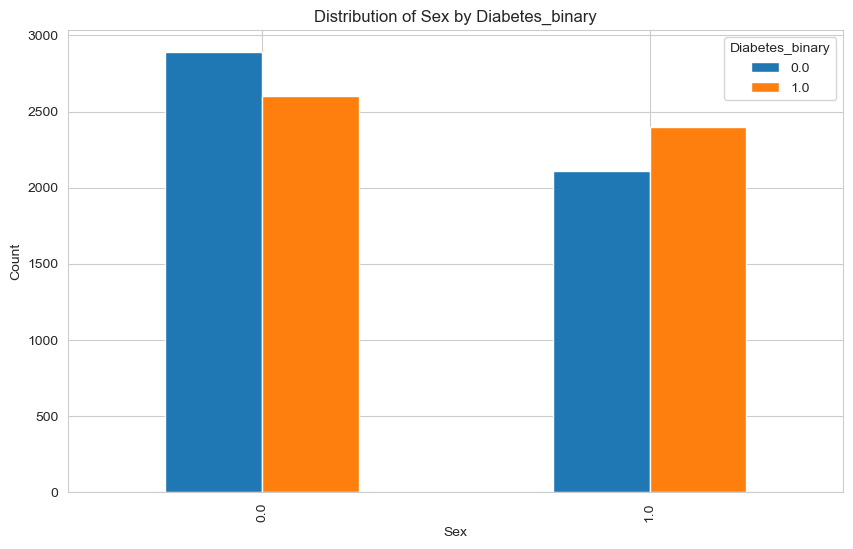

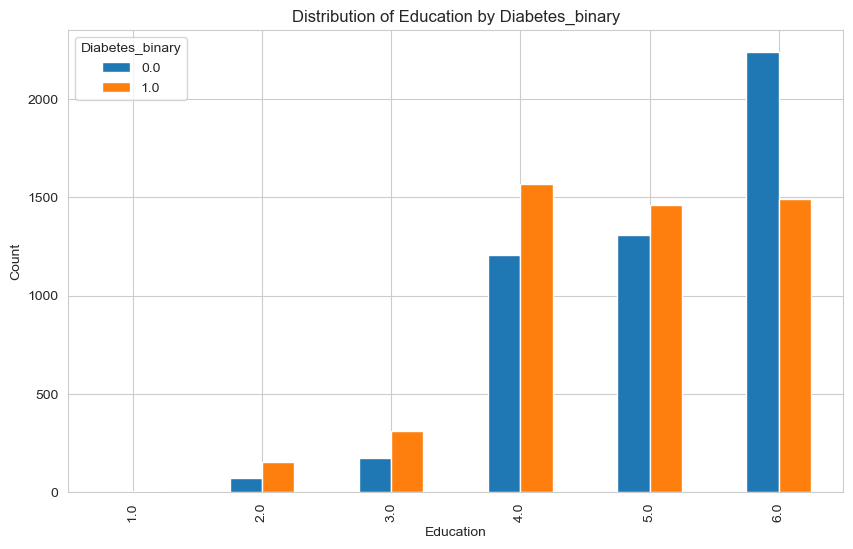

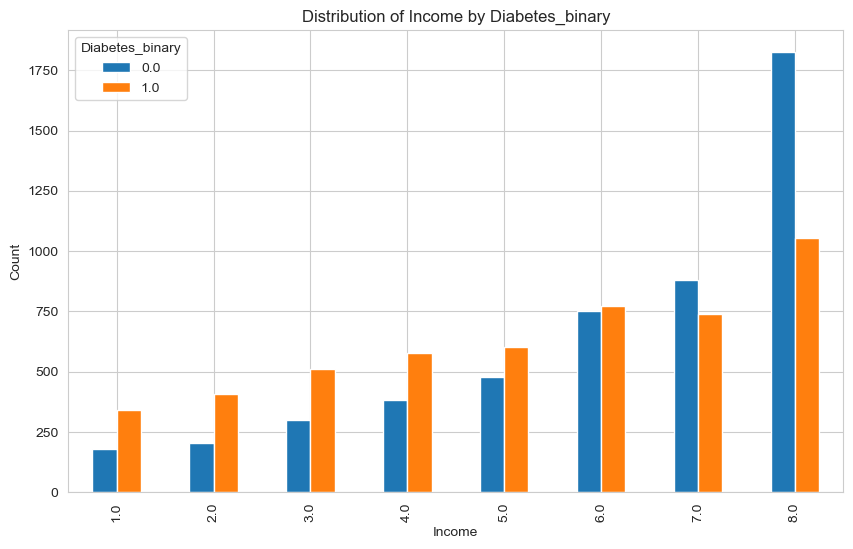

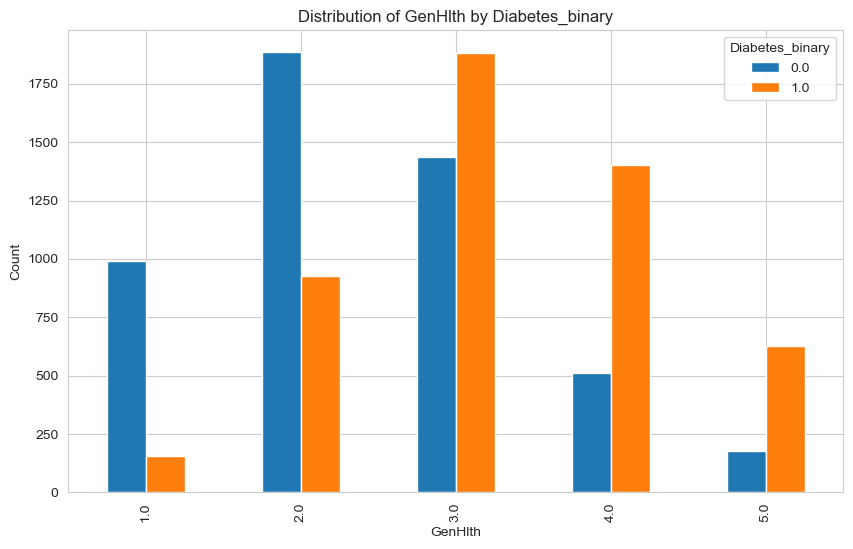

In [12]:
for col in binary_columns + nominal_columns:
    pd.crosstab(diabetes_data[col], diabetes_data[target_column]).plot(kind='bar', figsize=(10, 6))
    plt.title(f'Distribution of {col} by Diabetes_binary')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### Training the predictive model

Splitting the data and address the issue with imbalanced catagories in target variable

In [13]:
X = diabetes_data.drop('Diabetes_binary', axis=1)
y = diabetes_data['Diabetes_binary']

# First, split the data into a combined training + validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Then, split the combined training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)  # 0.2 validation of the original dataset

Training the models including:
+ LDA
+ QDA
+ Decision Tree
+ Random Forest
+ Logistic Regression
+ SVN
+ KNN
+ Neural Network
+ Catboost

In [14]:
def evaluate_model(model_name, model, X_train, y_train, X_val, y_val):
    # Note: Here, we refit the model using SMOTENC balanced training data
    model.fit(X_train, y_train)  # Use SMOTENC balanced data for fitting
    
    # Predict and evaluate on the validation set
    y_val_pred = model.predict(X_val)
    print(f"Results for {model_name} on Validation Data:")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred, zero_division=0))
    print("Accuracy: {:.2f}%\n".format(accuracy_score(y_val, y_val_pred) * 100))
    
    # Save the trained model
    joblib.dump(model, os.path.join(model_save_path, f"{model_name}.joblib"))

In [15]:
models = {
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVM": SVC(random_state=42),
    "k-NN": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=300)
}

# Check and create the model save directory if not exists
model_save_path = "models/"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

# Loop through each model, train using SMOTENC balanced data, evaluate on validation data, and save
for name, model in models.items():
    evaluate_model(name, model, X_train, y_train, X_val, y_val)

Results for LDA on Validation Data:
Confusion Matrix:
 [[720 280]
 [234 766]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      1000
         1.0       0.73      0.77      0.75      1000

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000

Accuracy: 74.30%

Results for QDA on Validation Data:
Confusion Matrix:
 [[655 345]
 [222 778]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.66      0.70      1000
         1.0       0.69      0.78      0.73      1000

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000

Accuracy: 71.65%

Results for Decision Tree on Validation Data:
Confusion Matrix:
 [[663 337]
 [391 609]]

Classification 

In [107]:
# Convert binary and nominal columns to integer type in the copied dataframes
for col in binary_columns + nominal_columns:
    X_train_numeric[col] = X_train_numeric[col].astype(int)
    X_val_numeric[col] = X_val_numeric[col].astype(int)
    X_test_numeric[col] = X_test_numeric[col].astype(int)

In [50]:
# Initialize and fit the CatBoostRegressor
model_cat = CatBoostClassifier(iterations=300, learning_rate=0.1, random_seed=42, cat_features=binary_columns + nominal_columns)
model_cat.fit(X_train_numeric, y_train, verbose=False, plot=False)

In [51]:
evaluate_model("Catboost", model_cat, X_train_numeric, y_train, X_val_numeric, y_val)

0:	learn: 0.6614788	total: 21.5ms	remaining: 6.44s
1:	learn: 0.6366081	total: 43.1ms	remaining: 6.42s
2:	learn: 0.6150237	total: 67.6ms	remaining: 6.69s
3:	learn: 0.5946488	total: 90.9ms	remaining: 6.72s
4:	learn: 0.5803760	total: 112ms	remaining: 6.61s
5:	learn: 0.5690359	total: 135ms	remaining: 6.63s
6:	learn: 0.5609618	total: 169ms	remaining: 7.06s
7:	learn: 0.5519024	total: 201ms	remaining: 7.35s
8:	learn: 0.5443675	total: 229ms	remaining: 7.42s
9:	learn: 0.5379394	total: 258ms	remaining: 7.5s
10:	learn: 0.5324462	total: 289ms	remaining: 7.59s
11:	learn: 0.5278431	total: 318ms	remaining: 7.63s
12:	learn: 0.5240502	total: 344ms	remaining: 7.6s
13:	learn: 0.5200122	total: 376ms	remaining: 7.69s
14:	learn: 0.5170393	total: 398ms	remaining: 7.56s
15:	learn: 0.5139195	total: 419ms	remaining: 7.45s
16:	learn: 0.5117259	total: 441ms	remaining: 7.34s
17:	learn: 0.5090112	total: 464ms	remaining: 7.27s
18:	learn: 0.5070539	total: 490ms	remaining: 7.24s
19:	learn: 0.5044825	total: 514ms	remai

Catboost has highest initial accuracy result. So the hyperparameter tuning will focus on Catboost

### Cross validation and hyper parameter tuning for Catboost

In [179]:
# Define the parameter grid for CatBoost
param_grid_cat = {
    'iterations': [200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize and configure GridSearchCV with the CatBoostClassifier
model_cat = CatBoostClassifier(random_seed=42, cat_features=binary_columns + nominal_columns, verbose=False)
grid_search_cat = GridSearchCV(estimator=model_cat, param_grid=param_grid_cat, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit GridSearchCV on the numeric training data
grid_search_cat.fit(X_train_numeric, y_train)

# Identify the best CatBoost model
best_cat_model = grid_search_cat.best_estimator_

# Predict on the validation set using the best model
y_val_pred_cat = best_cat_model.predict(X_val_numeric)

# Generate confusion matrix and calculate accuracy
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_cat))
print("Accuracy: {:.2f}%".format(accuracy_score(y_val, y_val_pred_cat) * 100))

# Save the best CatBoost model
joblib.dump(best_cat_model, "best_catboost_model.joblib")

# Get the results from the grid search and save them
cv_results_cat = grid_search_cat.cv_results_
results_df_cat = pd.DataFrame(cv_results_cat)
results_df_cat.to_csv("grid_search_results_catboost.csv", index=False)

Confusion Matrix:
 [[700 300]
 [189 811]]
Accuracy: 75.55%


### Test data result

In [180]:
# Predict on the test set using the best model
y_test_pred_cat = best_cat_model.predict(X_test_numeric)

# Generate confusion matrix and calculate accuracy
cm_test = confusion_matrix(y_test, y_test_pred_cat)
acc_test = accuracy_score(y_test, y_test_pred_cat)

print("Confusion Matrix:\n", cm_test)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_cat, zero_division=0))
print("Accuracy on test set: {:.2f}%".format(acc_test * 100))

Confusion Matrix:
 [[685 315]
 [198 802]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.69      0.73      1000
         1.0       0.72      0.80      0.76      1000

    accuracy                           0.74      2000
   macro avg       0.75      0.74      0.74      2000
weighted avg       0.75      0.74      0.74      2000

Accuracy on test set: 74.35%


In [181]:
best_cat_model.predict_proba(X_test_numeric)

array([[0.95417059, 0.04582941],
       [0.17905831, 0.82094169],
       [0.07661052, 0.92338948],
       ...,
       [0.29923821, 0.70076179],
       [0.18270684, 0.81729316],
       [0.56611229, 0.43388771]])

In [182]:
best_cat_model.predict(X_test_numeric)

array([0., 1., 1., ..., 1., 1., 0.])

### Tree SHAP

In [167]:
explainer_cat = shap.TreeExplainer(best_cat_model, X_test_numeric)
shap_values_cat = best_cat_model.get_feature_importance(data=catboost.Pool(X_test_numeric, label=y_test, cat_features=binary_columns + nominal_columns), type="ShapValues")
explainer_cat_train = shap.TreeExplainer(best_cat_model, X_train_numeric)
shap_values_cat_train = best_cat_model.get_feature_importance(data=catboost.Pool(X_train_numeric, label=y_train, cat_features=binary_columns + nominal_columns), type="ShapValues")

In [189]:
# Ensure JavaScript support is available for the Jupyter notebook
shap.initjs()
# Plot the force plot for the first prediction in the test sample
shap.force_plot(shap_values_cat[0][-1], shap_values_cat[0][:-1], X_test_numeric.iloc[0,:])

In [201]:
# Base value (expected value) for the predictions; assuming the same for all instances
# This typically represents the mean prediction or log-odds of the base output over the dataset
expected_value = shap_values_cat[0, -1] 

# SHAP values for all instances, excluding the last column which contains the base value
shap_values_for_100_instances = shap_values_cat[:100, :-1]

# Generate a force plot for all instances in the dataset
# Note: This might be very heavy to render if the dataset is large
shap.force_plot(expected_value, shap_values_for_all_instances, X_test_numeric)


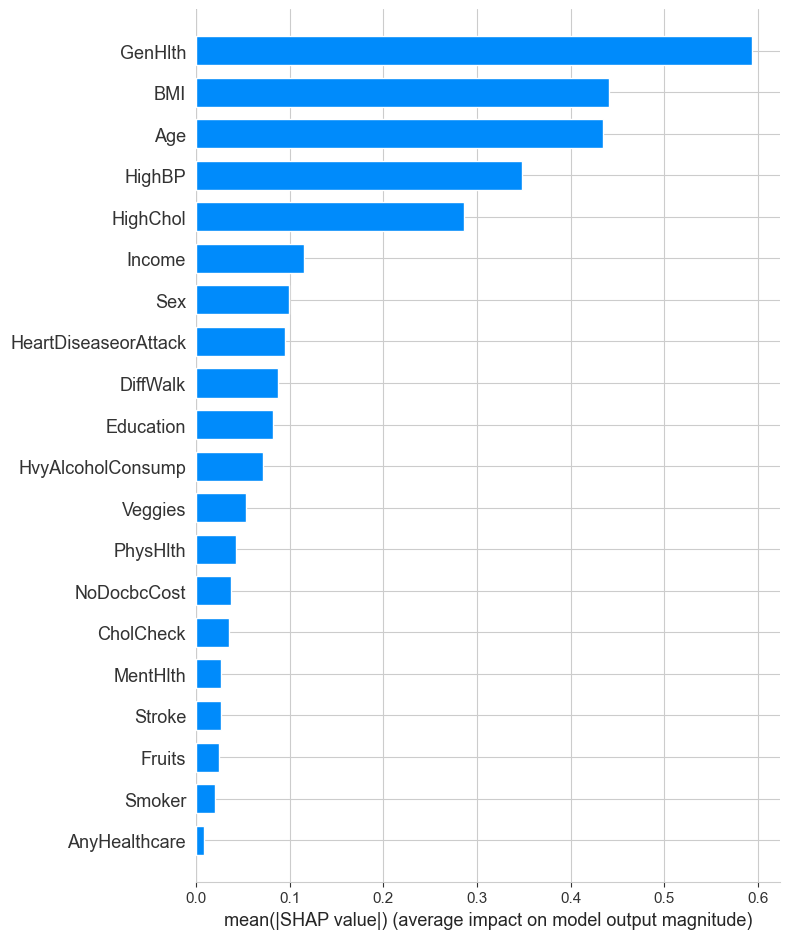

In [202]:
shap_values_for_all_instances = shap_values_cat[:, :-1]
shap.summary_plot(shap_values_for_all_instances, X_test_numeric, plot_type= "bar")

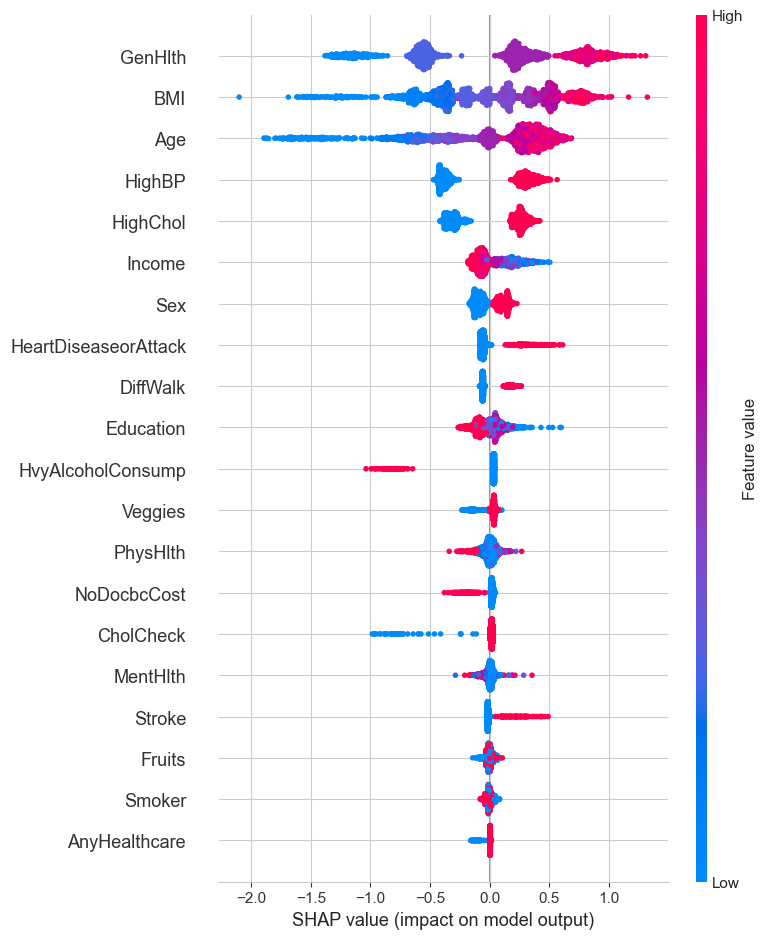

In [203]:
shap.summary_plot(shap_values_for_all_instances, X_test_numeric)

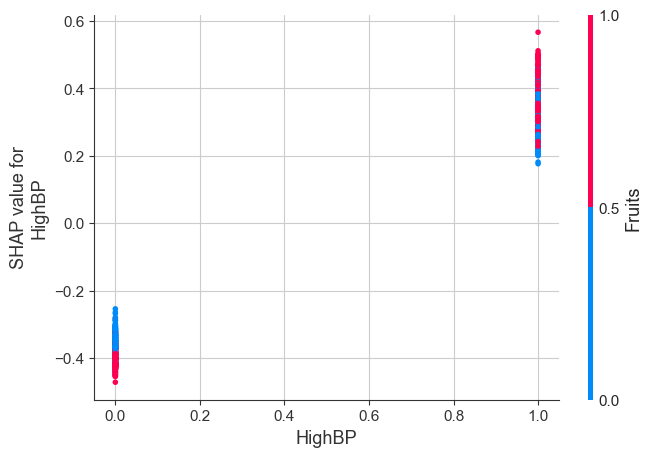

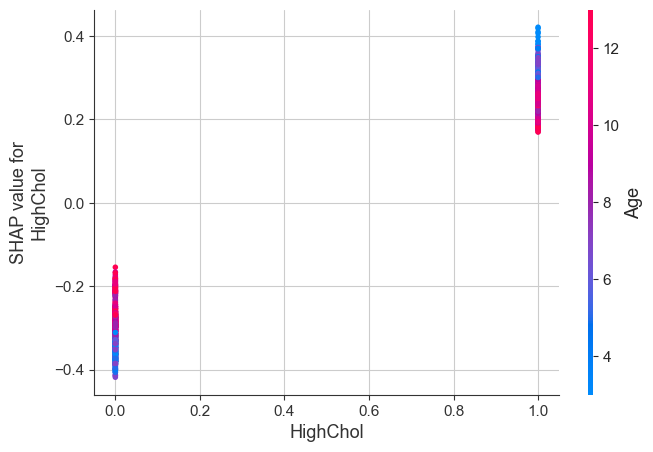

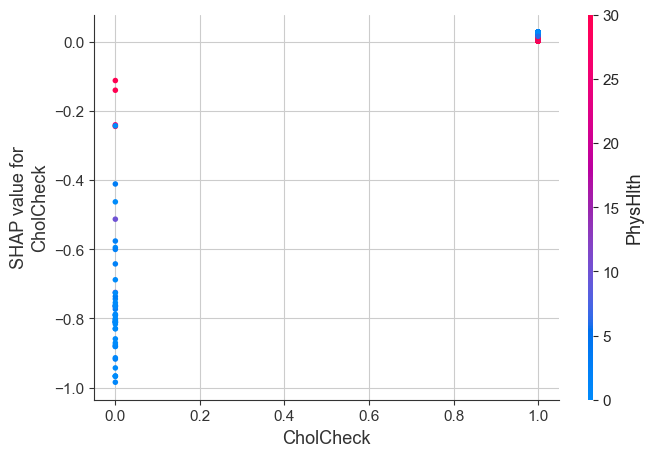

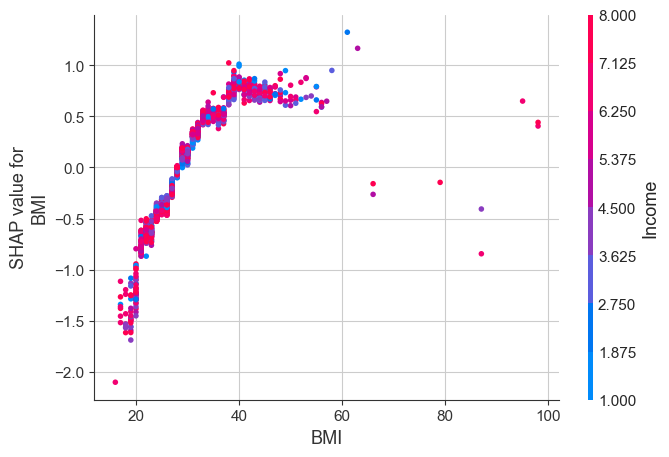

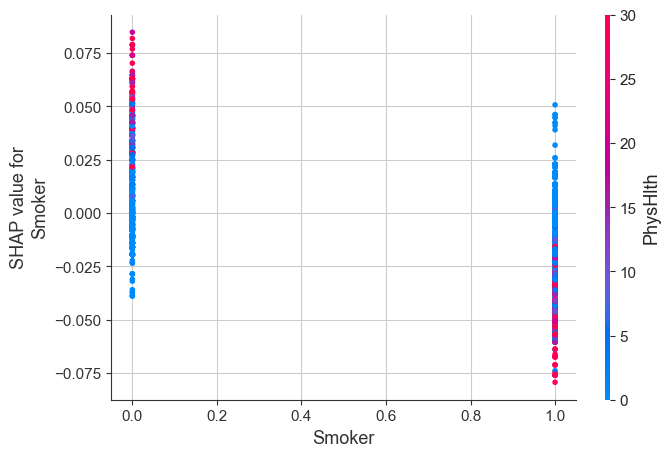

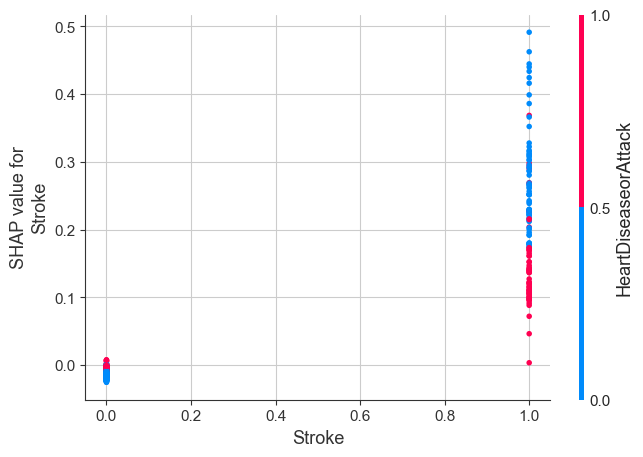

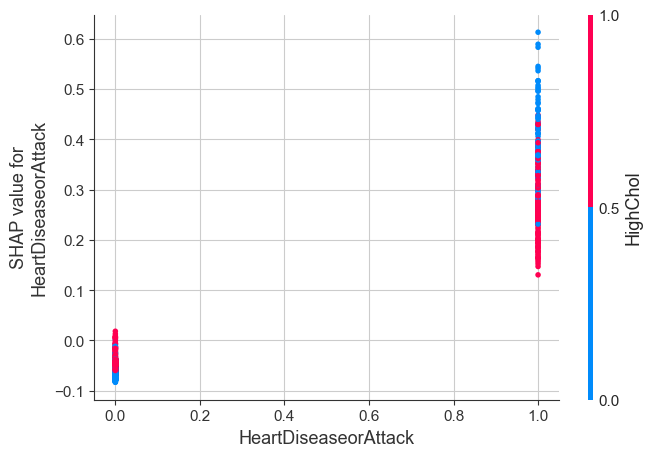

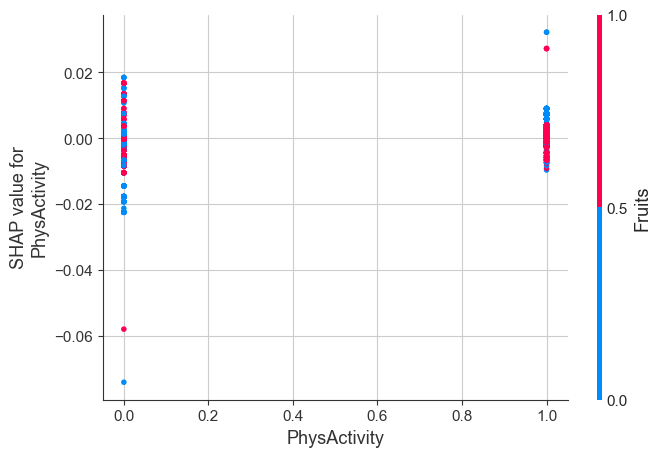

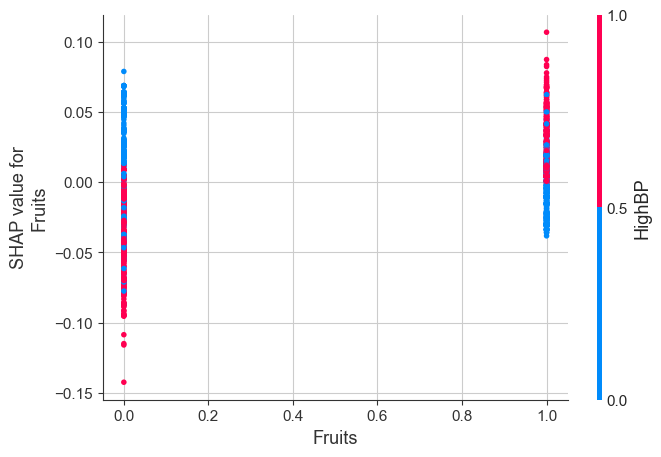

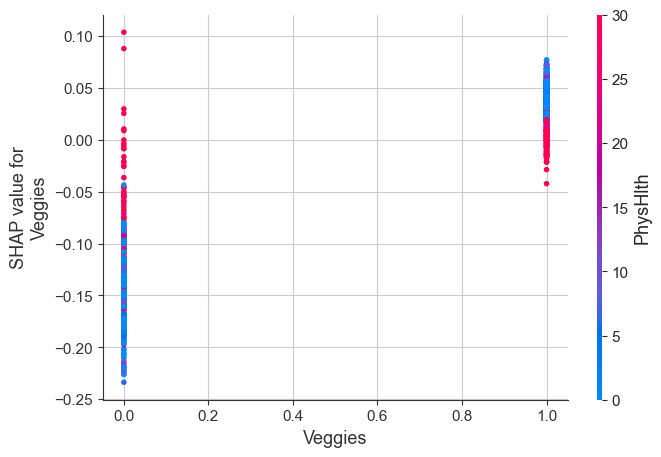

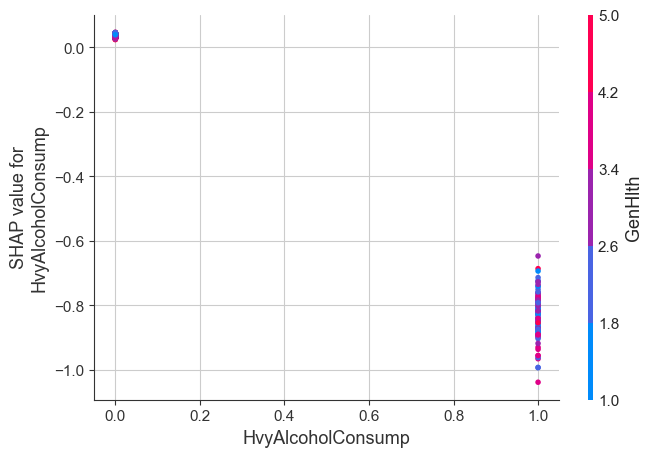

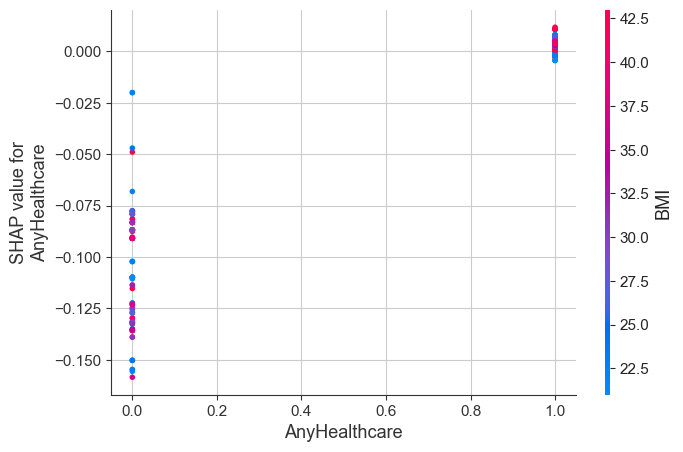

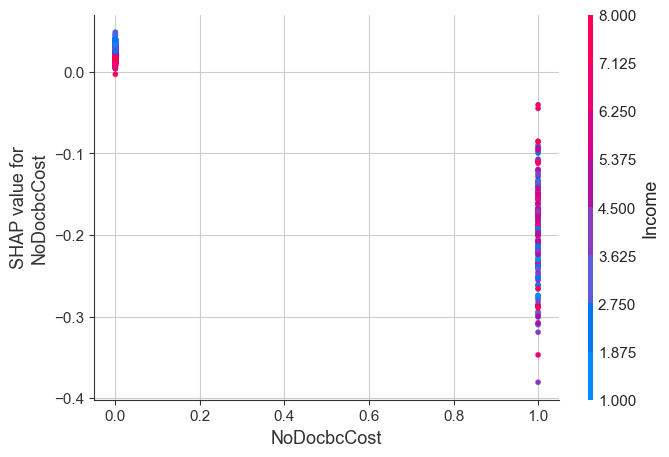

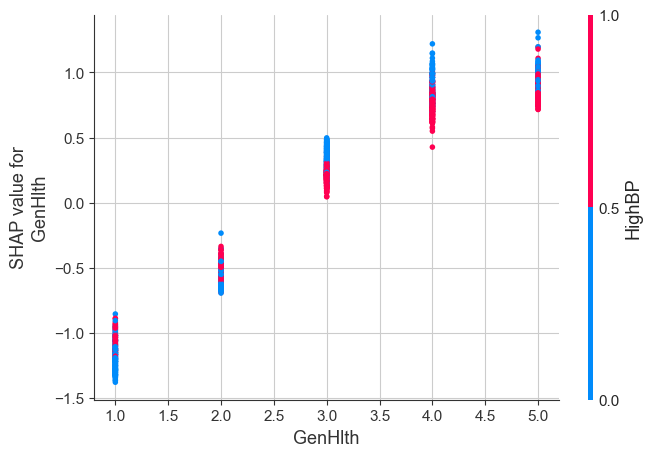

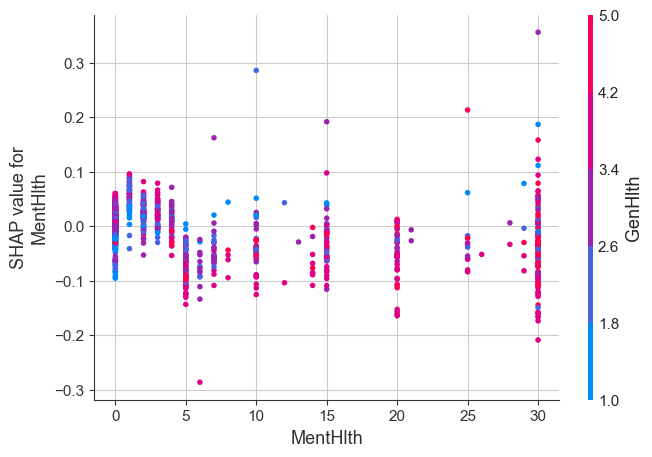

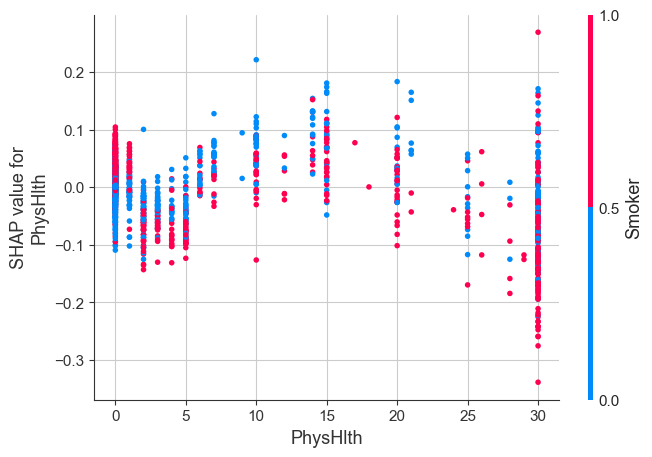

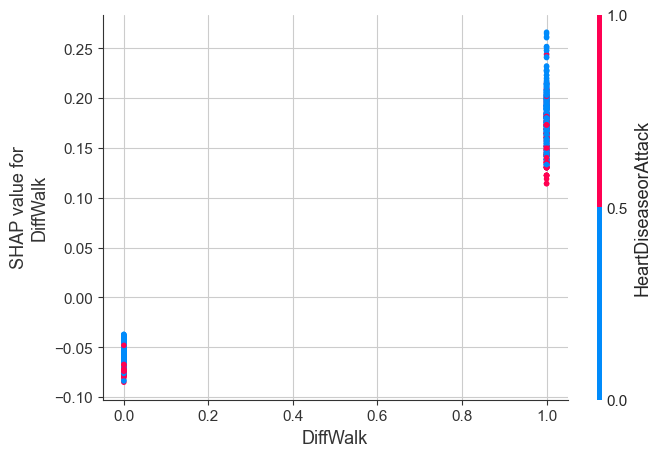

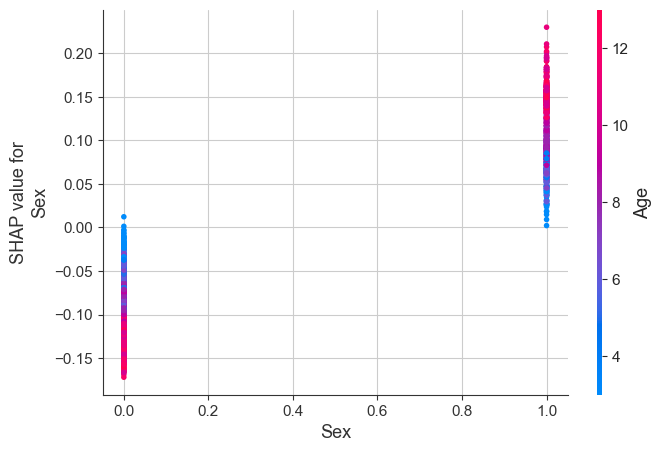

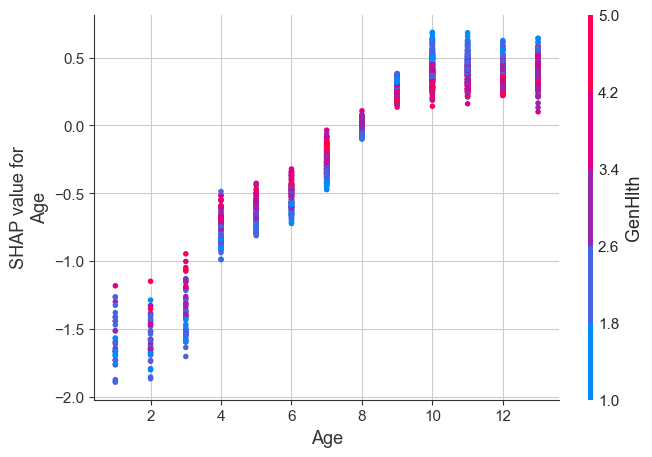

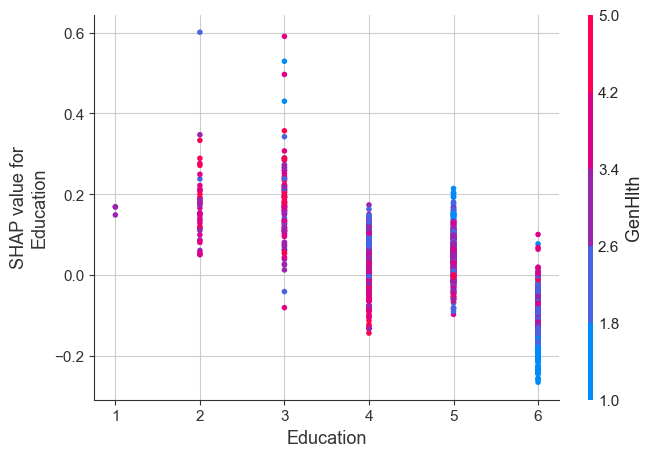

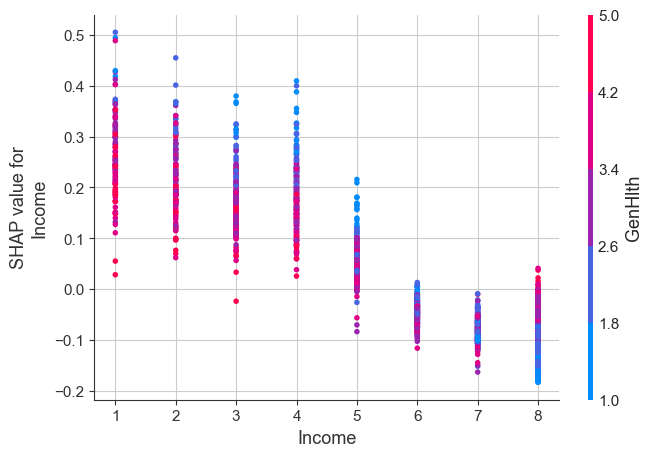

In [204]:
for name in X_test_numeric.columns:
    shap.dependence_plot(name, shap_values_for_all_instances, X_test_numeric)

### Measuring uncertainty

### Measuring uncertainty with the change in data

In [217]:
import numpy as np
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from catboost import Pool, CatBoostClassifier

# Set up parameters for stratified resampling
n_samples_per_category = 500  # number of samples per category
n_iterations = 50  # number of bootstrap iterations
num_features = X_train_numeric.shape[1]  # number of features

# Initialize arrays to store SHAP values across all iterations (excluding the base value column)
all_shap_values = np.zeros((n_iterations, n_samples_per_category * 2, num_features))

# Initialize stratified K-fold for resampling
skf = StratifiedKFold(n_splits=n_iterations, shuffle=True, random_state=42)

iteration = 0
for train_index, _ in skf.split(X_train_numeric, y_train):
    # Resample the training data
    X_resampled, y_resampled = X_train_numeric.iloc[train_index], y_train.iloc[train_index]
    X_resampled, y_resampled = resample(X_resampled, y_resampled, replace=False, n_samples=n_samples_per_category * 2, stratify=y_resampled)

    # Create a Pool with resampled data
    data_pool = Pool(data=X_resampled, label=y_resampled, cat_features=binary_columns + nominal_columns)

    # Compute SHAP values using CatBoost's get_feature_importance method
    shap_values = best_cat_model.get_feature_importance(data=data_pool, type="ShapValues")

    # Store SHAP values excluding the base value
    all_shap_values[iteration, :, :] = shap_values[:, :-1]

    iteration += 1

# Calculate mean and standard error of SHAP values across iterations for each feature
mean_shap_values = np.mean(all_shap_values, axis=0)
std_shap_values = np.std(all_shap_values, axis=0)
se_shap_values = std_shap_values / np.sqrt(n_iterations)

# Calculate the mean standard error across all samples for each feature
mean_se_per_feature = np.mean(se_shap_values, axis=0)

print("Mean SHAP values per feature across all bootstraps:", mean_shap_values.mean(axis=0))
print("Standard error of SHAP values per feature across all bootstraps:", mean_se_per_feature)

Mean SHAP values per feature across all bootstraps: [ 6.69904827e-03  2.06472723e-03  8.67349645e-07  1.53002312e-03
 -8.61966302e-04  1.48703600e-03 -2.64880219e-03  1.26374497e-03
 -1.54161716e-03  3.24132085e-04 -5.42539262e-03  1.18890051e-03
 -3.79854174e-04  1.95841244e-02  1.35097812e-03 -7.82326861e-03
 -3.61825319e-04  6.01822519e-04 -3.73749124e-04 -7.91768750e-04
  4.66095167e-03]
Standard error of SHAP values per feature across all bootstraps: [0.04874198 0.03890898 0.01675874 0.08152822 0.00625616 0.01187399
 0.01768146 0.00275346 0.00485753 0.01088052 0.02728615 0.00387074
 0.01035743 0.10144096 0.0076498  0.01200111 0.01328604 0.01604127
 0.07495717 0.0162792  0.02309173]


### GP predictive explanation

In [230]:
X_train.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [220]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Example for a single feature's SHAP values
feature_index = 0  # Example for the first feature
shap_values_for_feature = shap_values_cat_train[:, feature_index]  

# Initialize Gaussian Process
kernel = DotProduct() + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel)

# Fit GP model for this feature's SHAP values
gp.fit(X_train, shap_values_for_feature)

# Predict SHAP values for the validation set
predicted_shap_values_for_feature = gp.predict(X_test)

# Compare predicted SHAP values to actual SHAP values for the feature
# You might use visualization or statistical measures for comparison

In [222]:
predicted_shap_values_for_feature

array([-0.35552341,  0.31553442,  0.26907388, ...,  0.32794697,
        0.33743113,  0.32930507])

In [228]:
np.array([i for i in shap_values_cat[:, feature_index]])

array([-0.42521353,  0.26764172,  0.24557162, ...,  0.30357834,
        0.34339668,  0.31482684])

### GP-SHAP for one feature

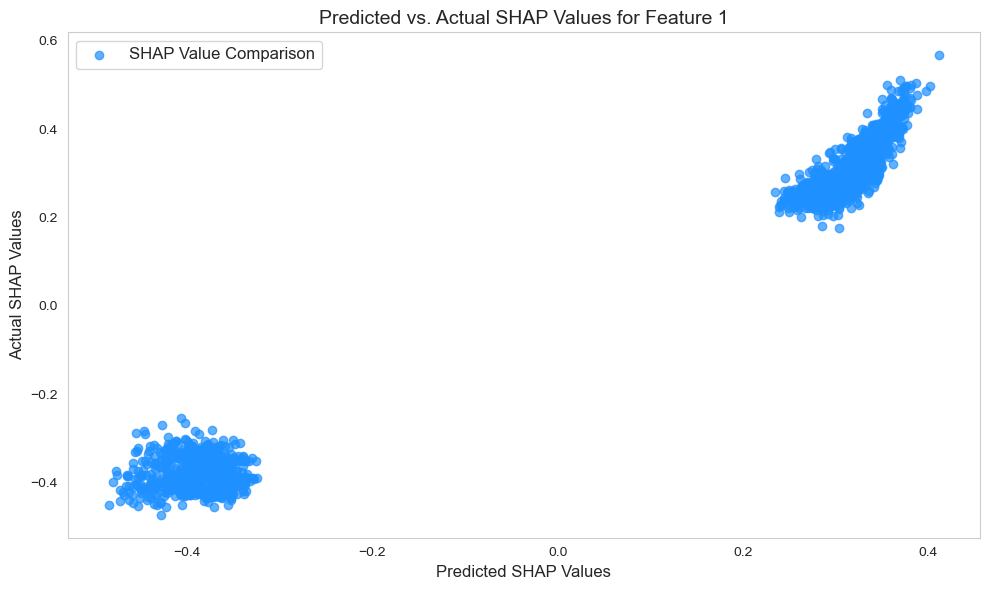

In [229]:
# Creating the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(
    predicted_shap_values_for_feature,
    np.array([i for i in shap_values_cat[:, feature_index]]),
    alpha=0.7,
    color='dodgerblue',  # You can change the color as needed
    label='SHAP Value Comparison'  # Add label for legend if needed
)

# Adding plot decorations
plt.title('Predicted vs. Actual SHAP Values for Feature 1', fontsize=14)  # Add plot title
plt.xlabel('Predicted SHAP Values', fontsize=12)  # Add x-axis label
plt.ylabel('Actual SHAP Values', fontsize=12)  # Add y-axis label
plt.legend(fontsize=12)  # Show legend, adjust font size as needed

plt.grid(False)  # Disable grid lines
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()  # Display the plot

### Implement GP-SHAP for every feature

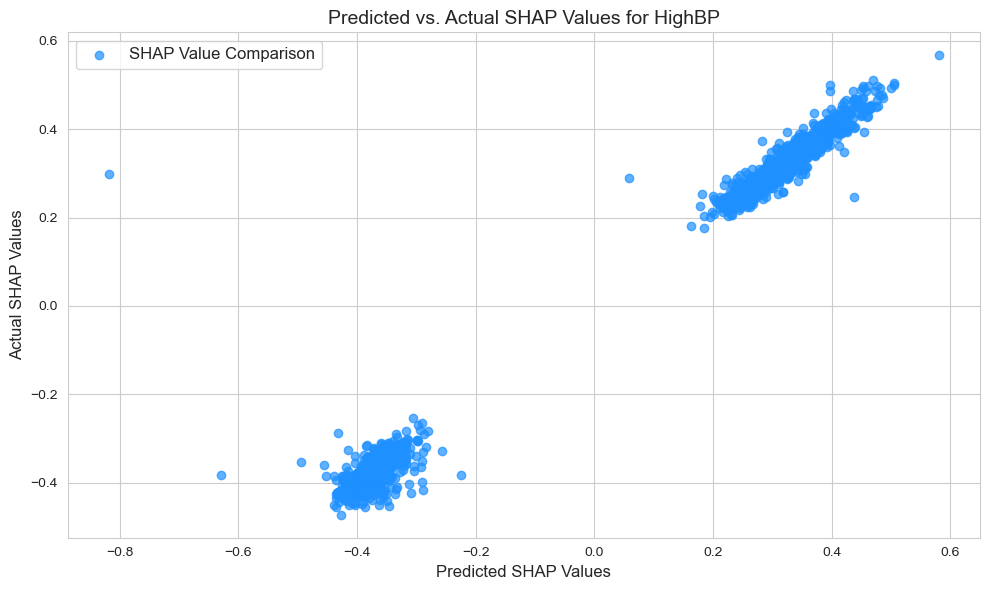

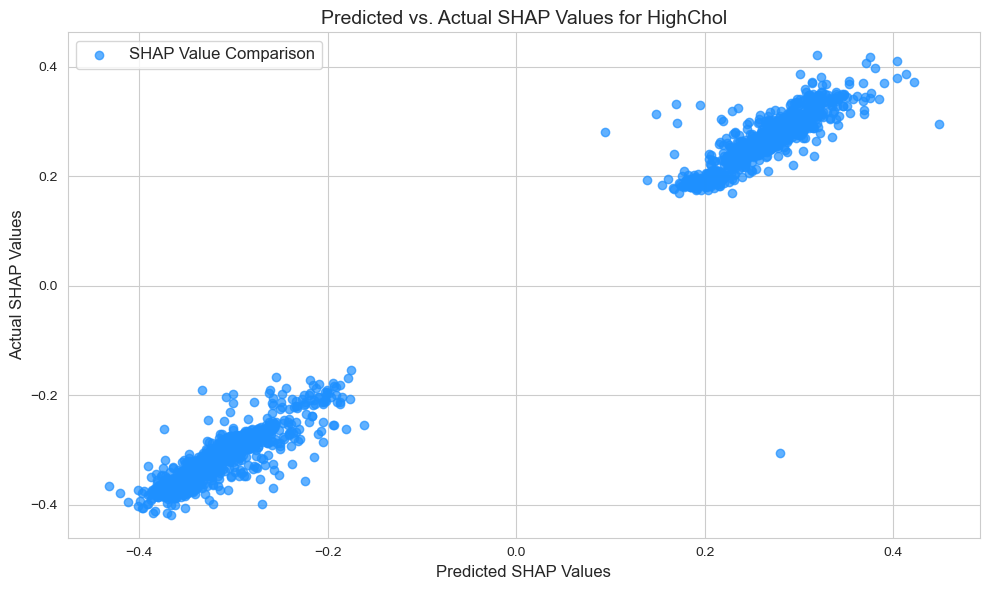

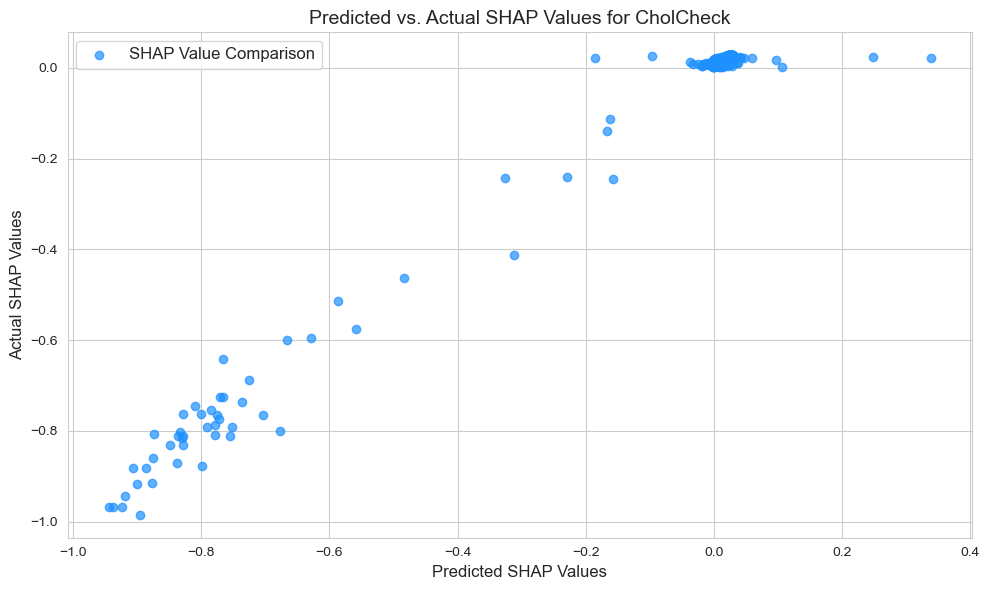

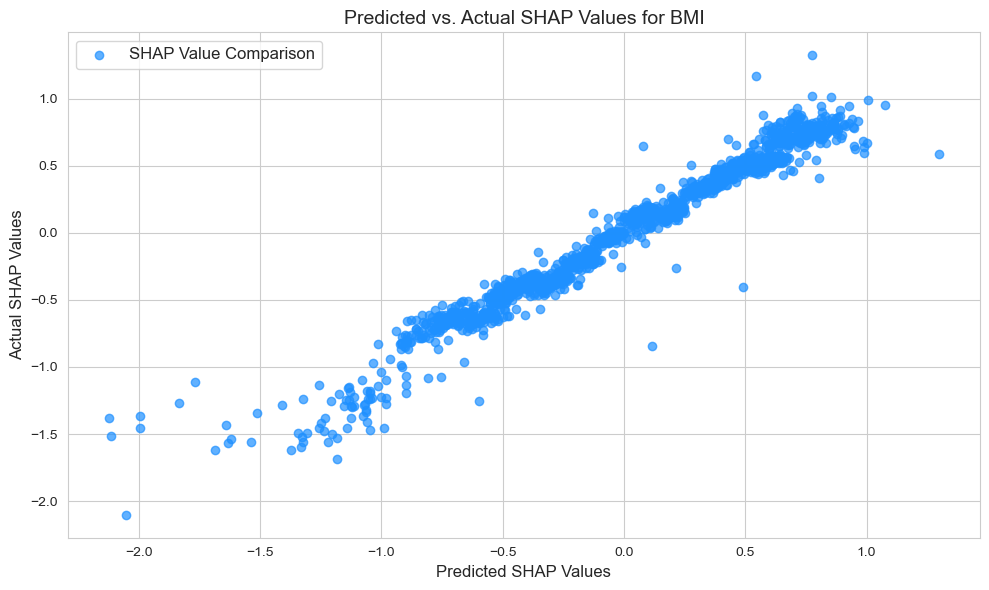

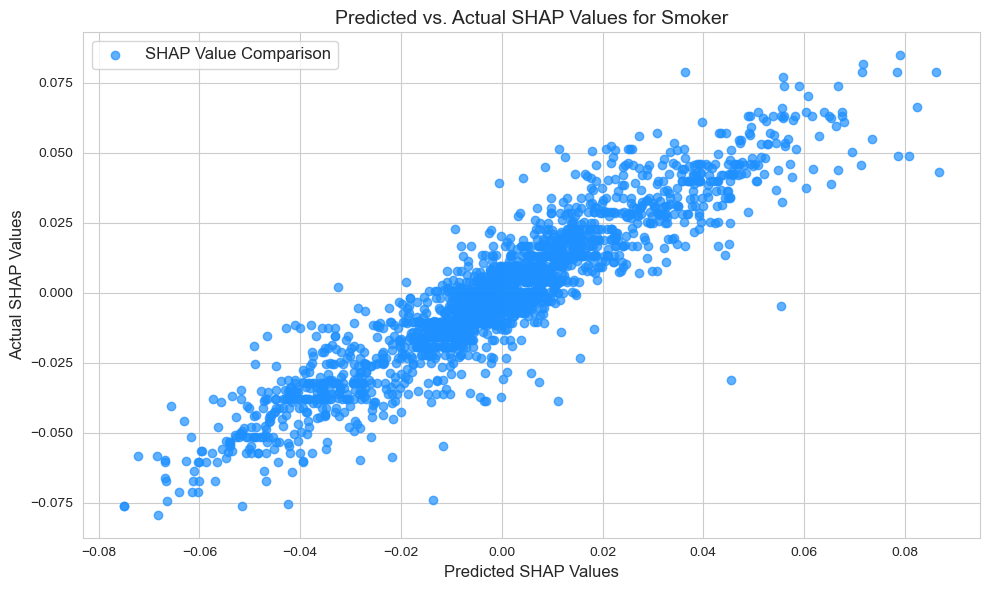

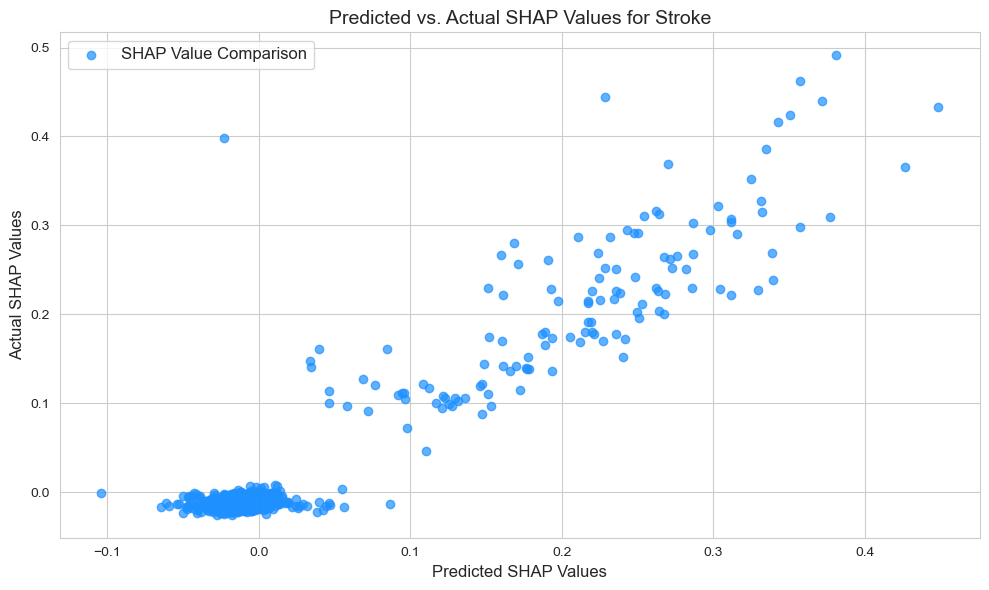

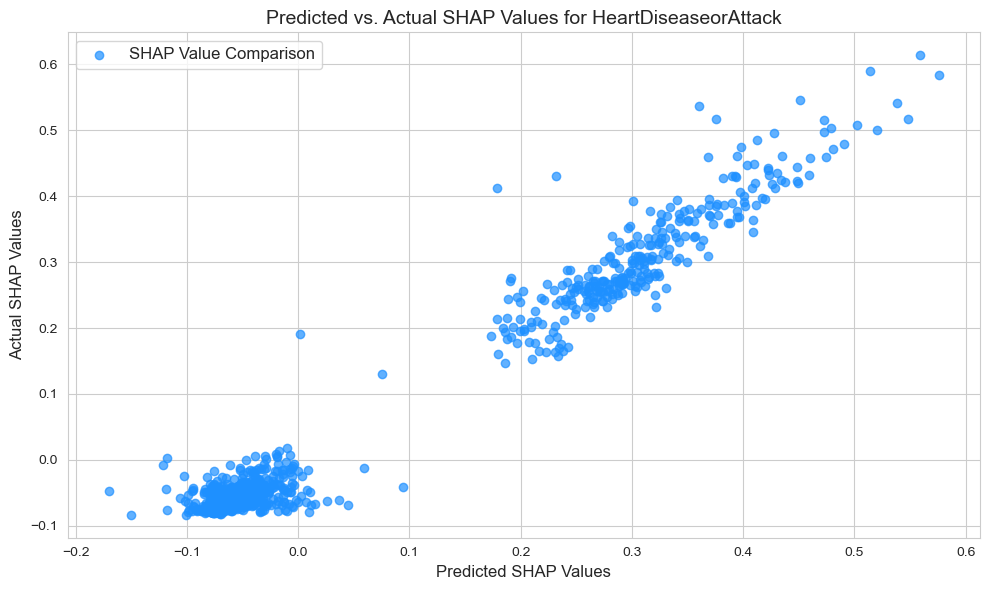

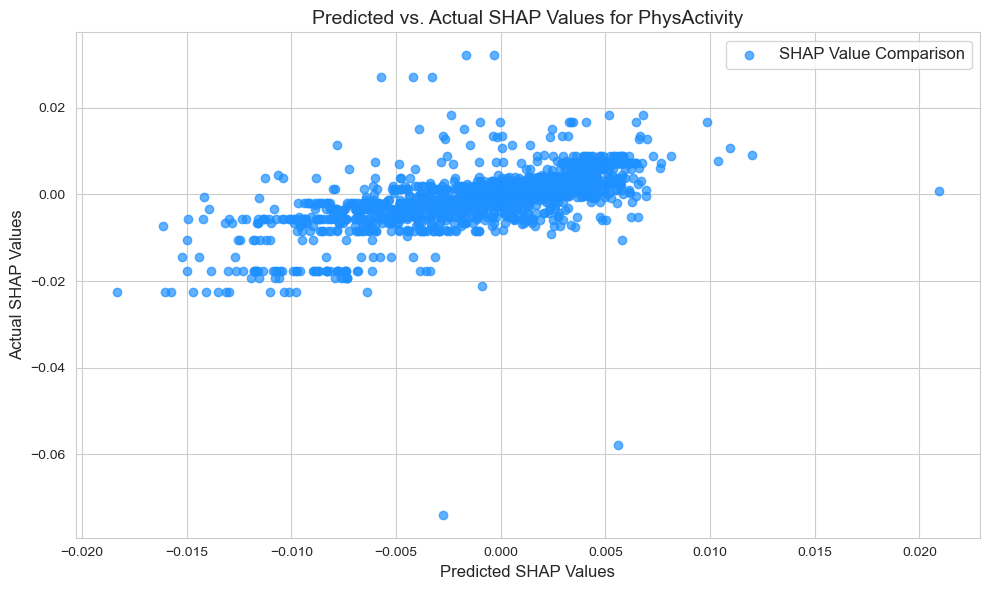

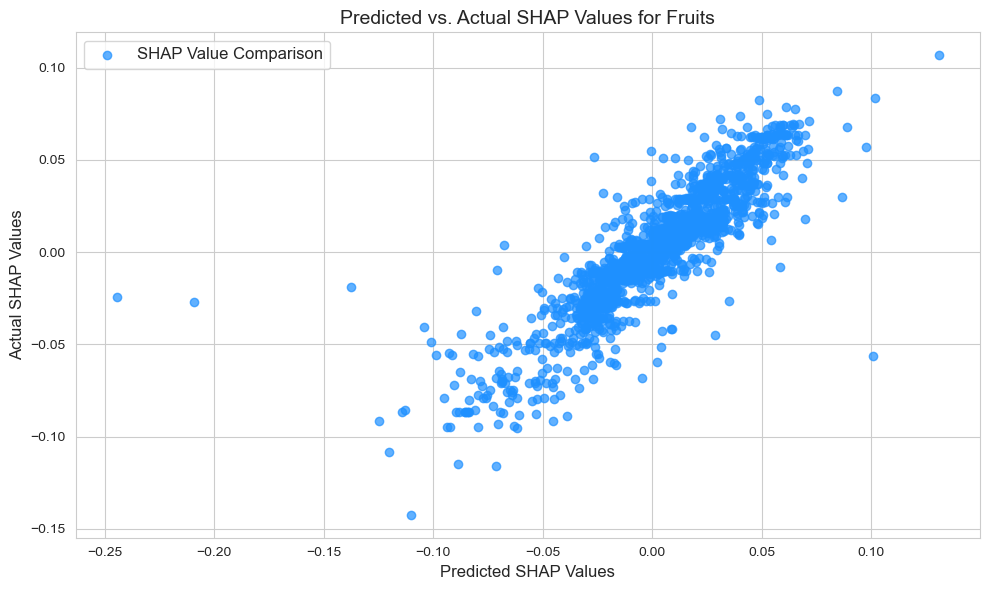

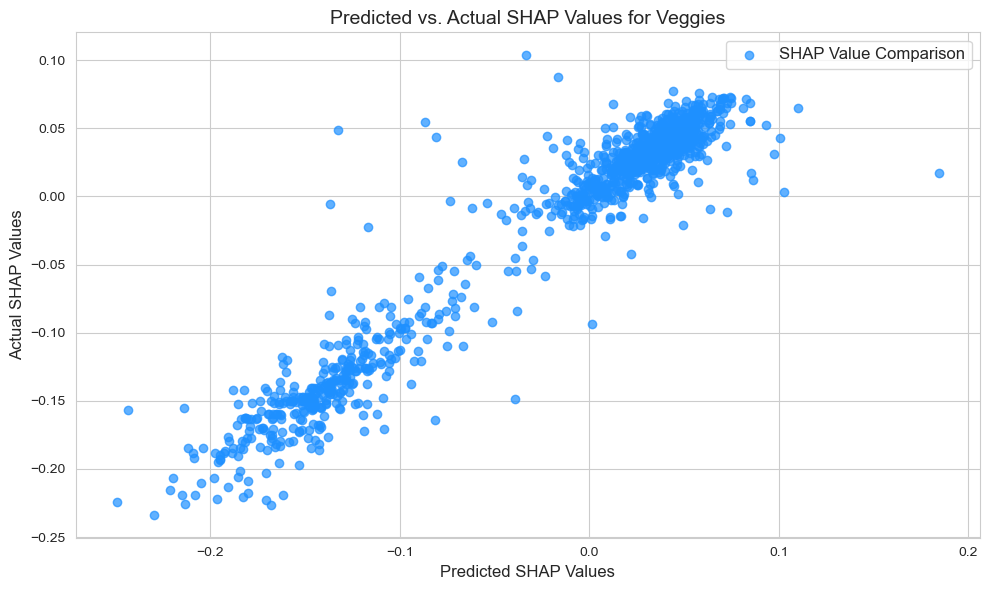

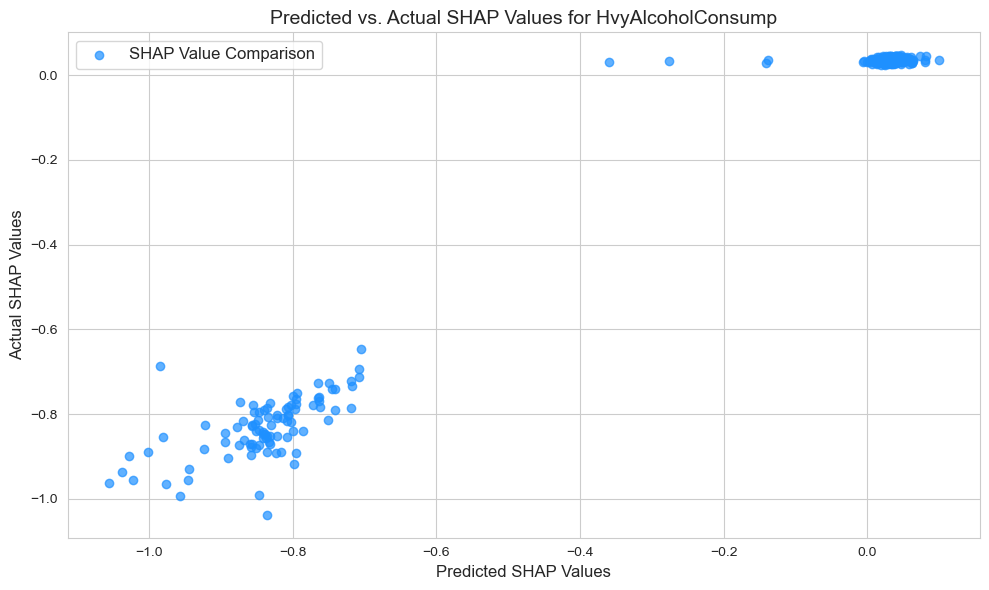

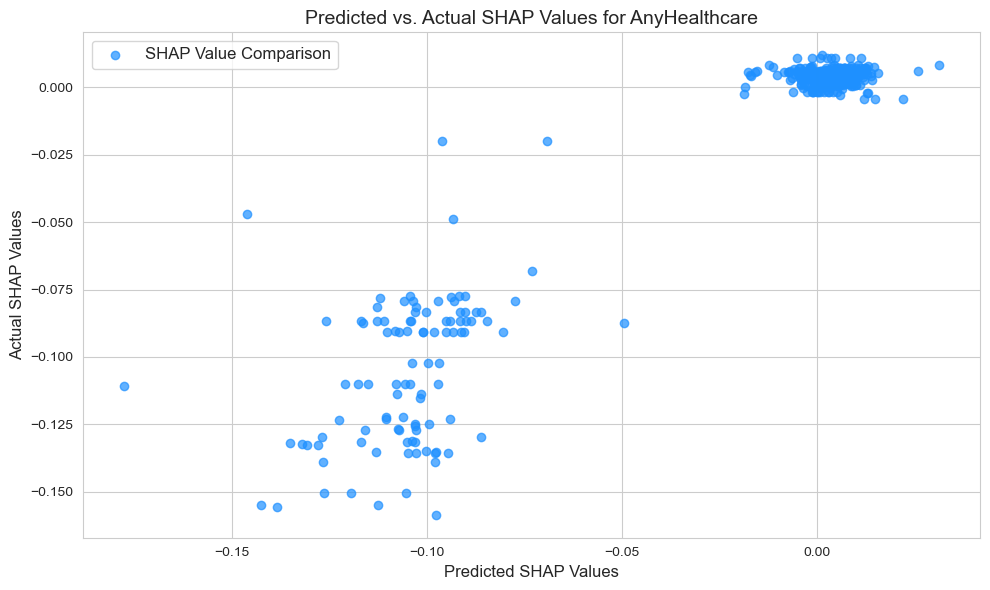

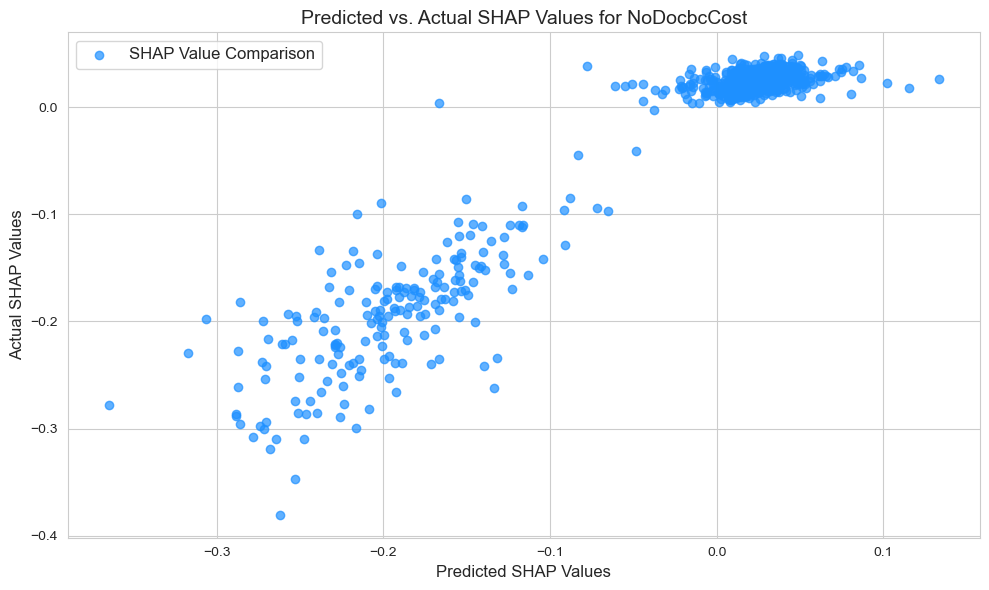

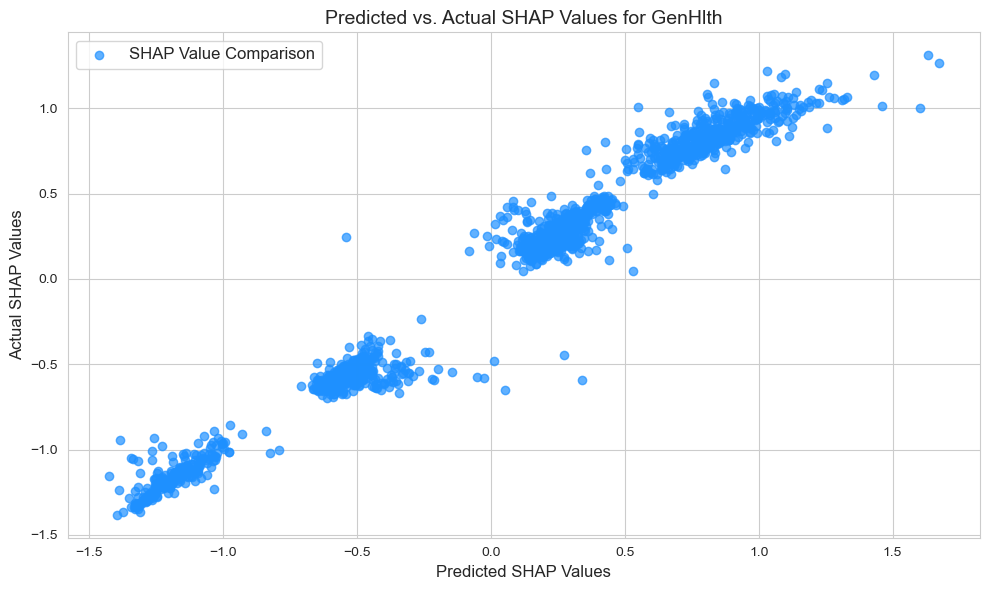

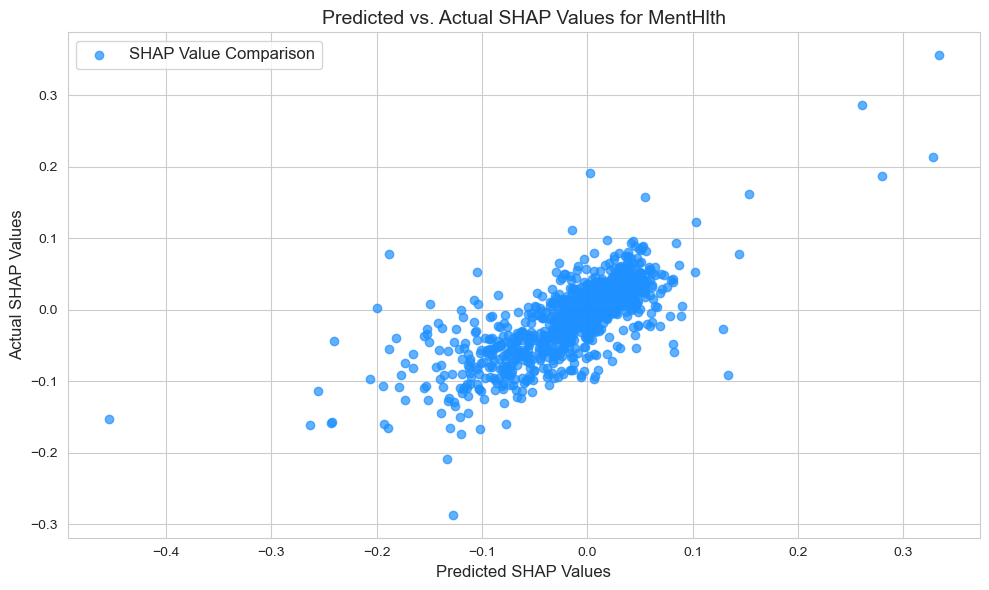

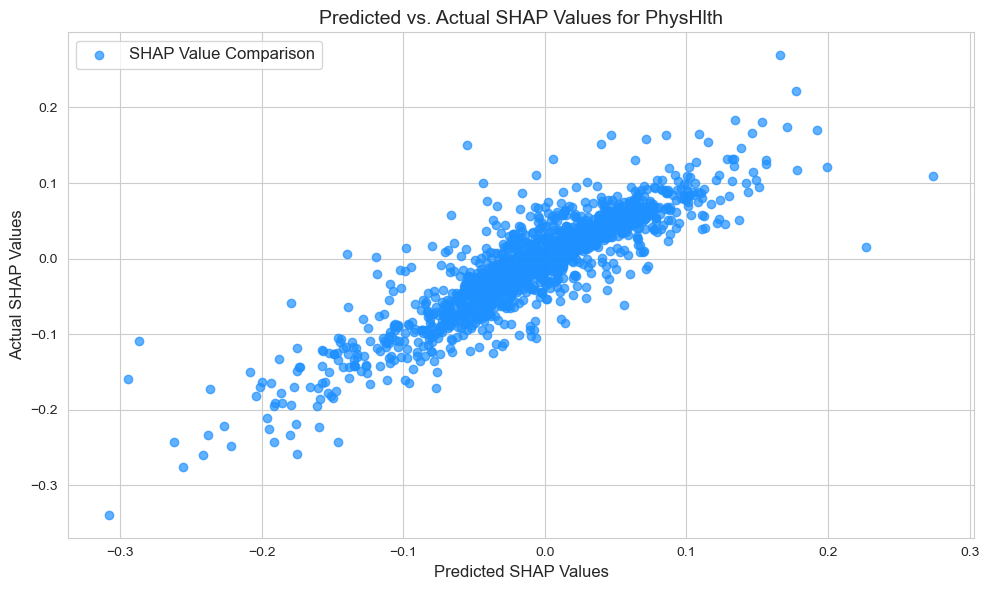

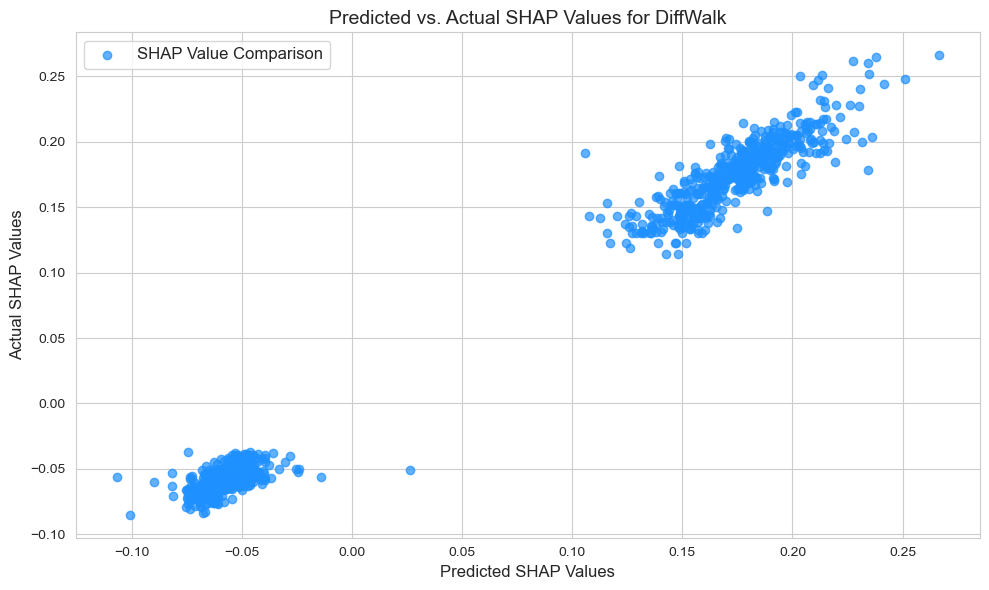

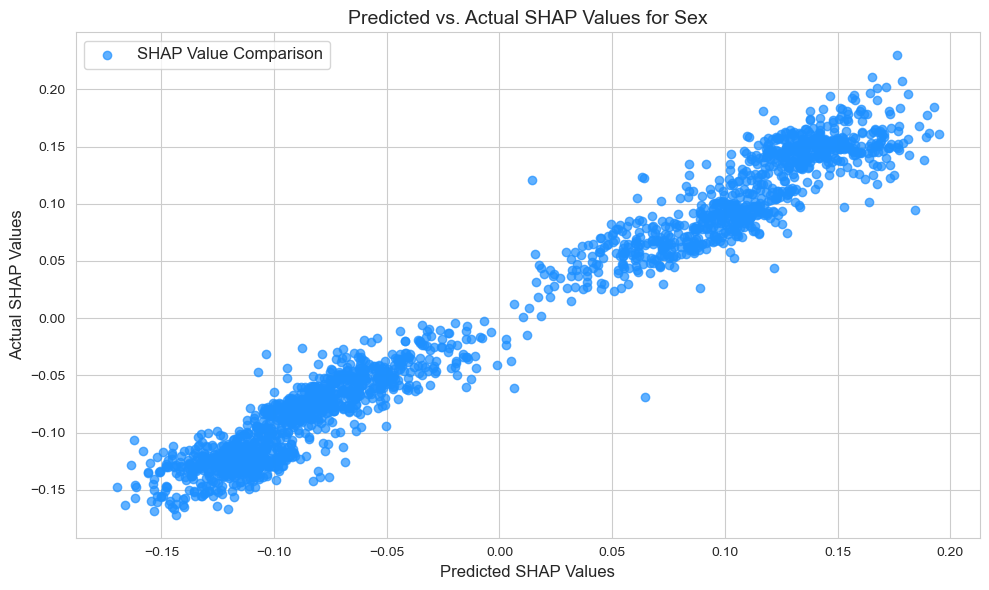

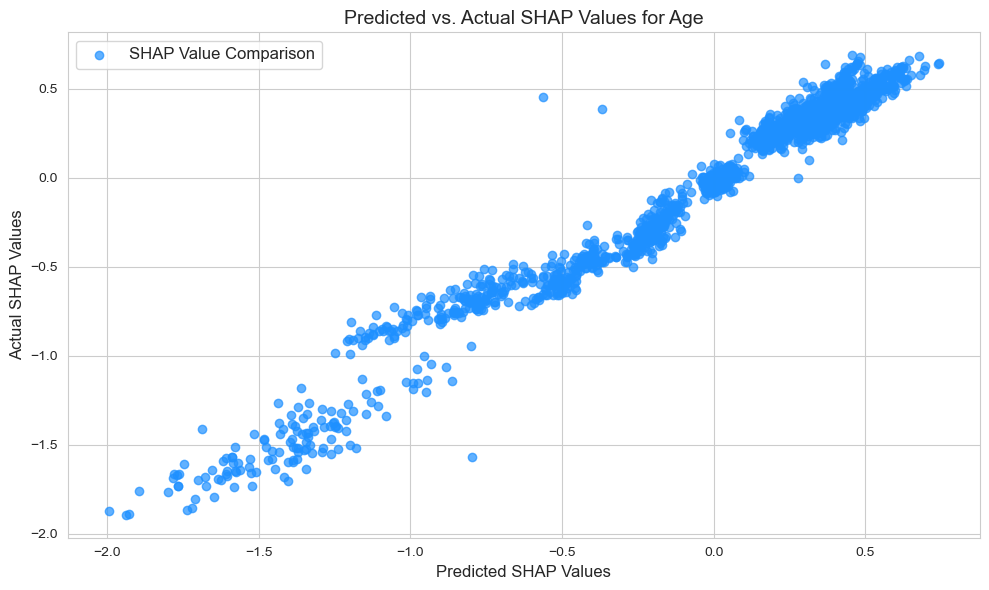

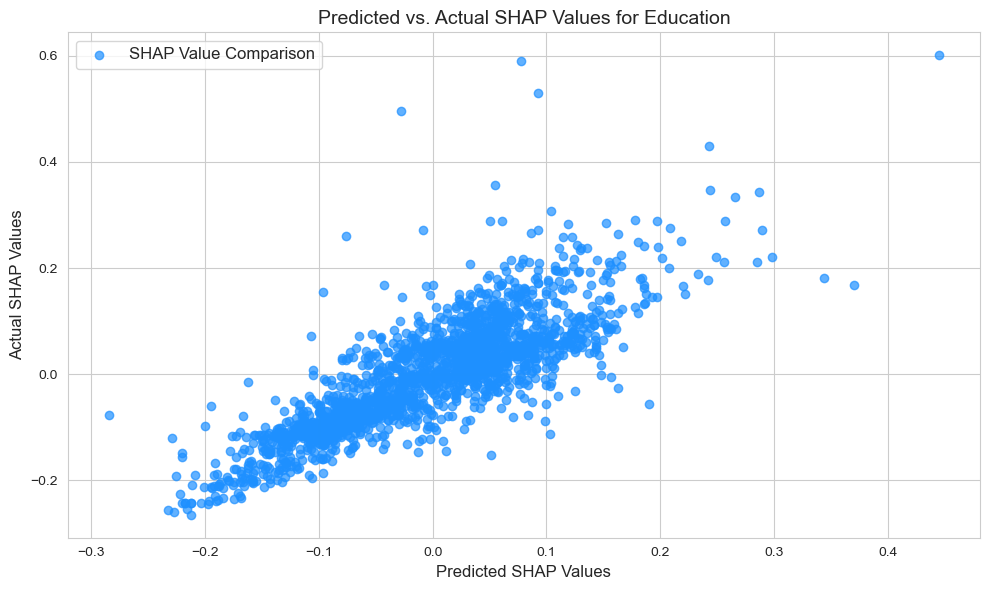

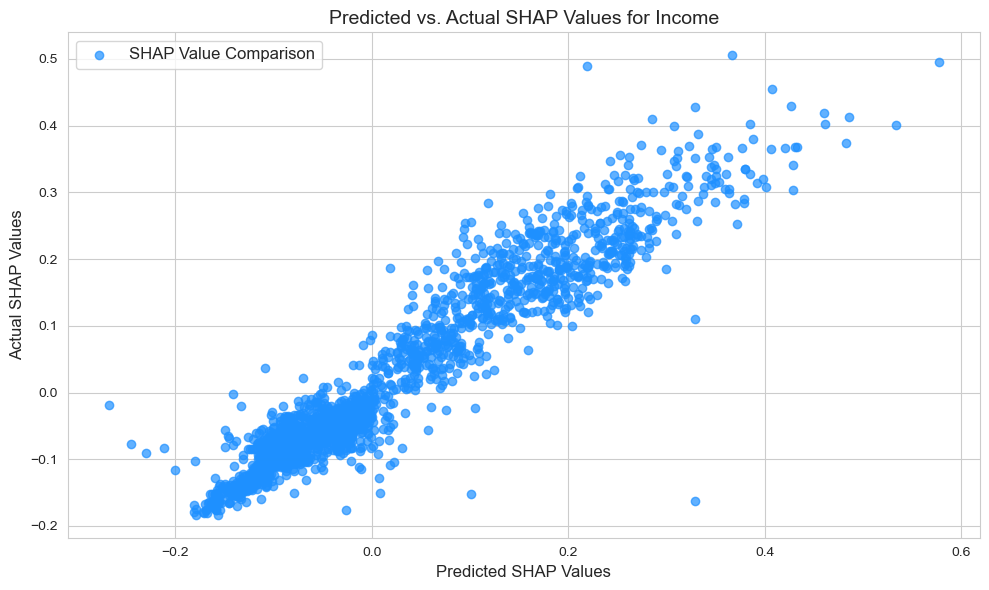

In [232]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a directory for the plots if it doesn't exist
plots_directory = "GPshap_plots"
os.makedirs(plots_directory, exist_ok=True)

# Assuming shap_values_cat_train is a numpy array where each column represents SHAP values for a feature
feature_names = ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
                 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
                 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
                 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
                 'Income']

# Initialize the Gaussian Process with an RBF kernel combined with a White kernel to handle noise
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gp = GaussianProcessRegressor(kernel=kernel)

# Loop through each feature index and its corresponding name
for feature_index, feature_name in enumerate(feature_names):
    # Extract SHAP values for the current feature
    shap_values_for_feature = shap_values_cat_train[:, feature_index]

    # Fit GP model for this feature's SHAP values
    gp.fit(X_train, shap_values_for_feature)

    # Predict SHAP values for the validation set
    predicted_shap_values_for_feature = gp.predict(X_test)

    # Creating the scatter plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.scatter(
        predicted_shap_values_for_feature,
        np.array([i for i in shap_values_cat[:, feature_index]]),
        alpha=0.7,
        color='dodgerblue',  # You can change the color as needed
        label='SHAP Value Comparison'  # Add label for legend if needed
    )

    # Adding plot decorations
    plt.title(f'Predicted vs. Actual SHAP Values for {feature_name}', fontsize=14)  # Add plot title
    plt.xlabel('Predicted SHAP Values', fontsize=12)  # Add x-axis label
    plt.ylabel('Actual SHAP Values', fontsize=12)  # Add y-axis label
    plt.legend(fontsize=12)  # Show legend, adjust font size as needed

    plt.grid(True)  # Enable grid lines for better readability
    plt.tight_layout()  # Adjust layout to not cut off labels
    
    # Save the plot to a file in the specified directory
    plt.savefig(f"{plots_directory}/{feature_name}_shap_comparison.png")
    
    plt.show()  # Display the plot